### Loading the super-tensor and creating the temporal networks

In this notebook we will explore the class __temporal_nets__ to compute preliminar results using network analysis.

In [1]:
# Importing the temporal network class
from   GDa.temporal_network              import temporal_network
from   GDa.graphics.plot_raster          import plot_nodes_raster_all_bands 
from   GDa.graphics.plot_coherence_dists import plot_pooled_coherence_dists, plot_pooled_coherence_dists_per_stage, plot_pooled_coherence_dists_per_stim
from   GDa.graphics.plot_adjacency       import plot_adjacency 
import numpy                 as     np
import networkx              as     nx
import matplotlib.pyplot     as     plt
import igraph                as     ig
import leidenalg
import scipy.signal
import time
from   tqdm                  import tqdm
from   joblib                import Parallel, delayed
from   scipy                 import stats

# Just an auxiliary function to sommoth plots
def smooth(x, w):
    return scipy.signal.fftconvolve(x, np.ones(w)/w, mode='same')
# Bands names
bands = [r'$\theta$', r'$\alpha$', r'$\beta$', r'$\gamma$ ']

To instantiate the __temporal_network__ we have to supply the monkey name, the session, and date to its constructor.

In [2]:
# Instantiating a temporal network object
net = temporal_network(monkey='lucy', session=1, date=150128)

When instantiated, the temporal network object will load the recording info for the monkey, date, and sesion specified as well as the super tensor;

The super-tensor has dimensions [Number of pairs, Number of frequency bands, Number of trials * Time] (i.e., the trials are concatenated). So far we are using the following bands:

- $\theta$  = [4,8]  Hz;
- $\alpha$  = [8,15]  Hz;
- $\beta$   = [15,30]  Hz;
- $\gamma$  = [30,60]  Hz;

It is possible to check which recording information was recordes by acessing the __session_info__ dictionary:

In [3]:
print('Recording info available:\n')
print(list(net.session_info.keys()))

Recording info available:

['nC', 'nP', 'nT', 'pairs', 'indt', 'fsample', 'tarray', 'channels_labels', 'dcue', 'dsm', 'stim', 'indch', 'areas', 't_cue_on', 't_cue_off', 't_match_on']


We can plot the super tensor to visualize the time series of link strength for each band (here we plot 10 trials for better visualization).

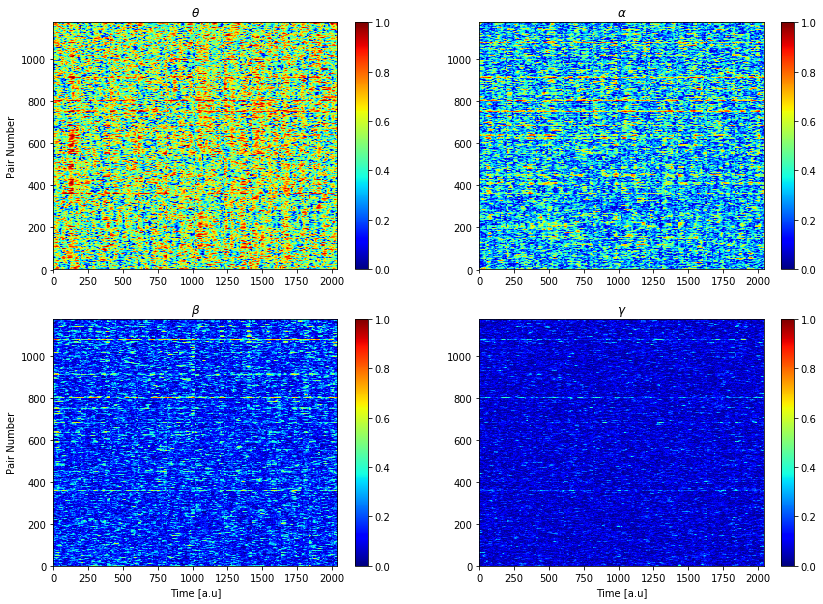

In [55]:
plot_nodes_raster_all_bands(net.super_tensor[:,:,:10*len(net.tarray)], 
                            0, 10*len(net.tarray), 
                            1, net.session_info['nP'], 0, 1, 
                            'Pair Number', 'Time [a.u]', bands, (14,10), 'jet')
plt.savefig('figures/layerwise_net/super_tensor_no_trim.png')

Notice that strong vertical stripes appear at the beggining/ending of each trial in the image above. This is due artifacts during wavelet estimation of pairwise coherences. To remove the border artifacts it is possible to instantiate the __temporal_network__ class specifing the parameter __trim_borders__ = True, and a value to the parameter __wt__. Doing that the firs and last __wt__ time points of the super tensor and the time array will be removed.

In [5]:
# Instantiating a temporal network object specifing trim_borders and wt.
net =  temporal_network(monkey='lucy', session=1, date=150128, trim_borders=True, wt=20)

Now let's plot the super tensor for the first ten trials again and observe that now the vertical stripes are gone.

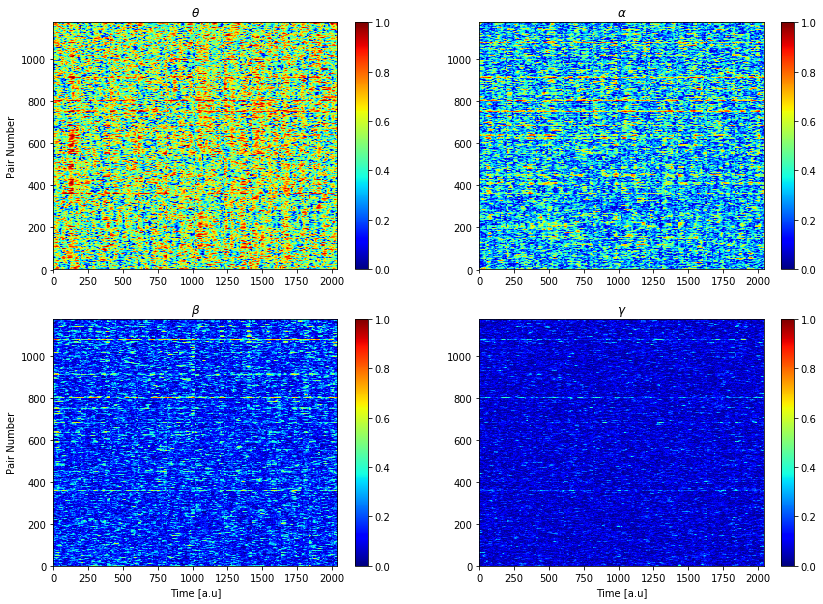

In [56]:
plot_nodes_raster_all_bands(net.super_tensor[:,:,:10*len(net.tarray)], 
                            0, 10*len(net.tarray), 
                            1, net.session_info['nP'], 0, 1, 
                            'Pair Number', 'Time [a.u]', bands, (14,10), 'jet')
plt.savefig('figures/layerwise_net/super_tensor.png')

Some of the network theory measures can be applied to the binarized version of the network and in order to do so it is necessary to define thresholds for the coherence values, this can be done with the method __compute_coherence_thresholds__, this method receives a parameter __q__ between $0$ and $1$ that specifies that only links with coherence values in the top $(1-q)$ of the distribution will be kept.

Threshold in $\delta$ band = 0.6973007619380951
Threshold in $\alpha$ band = 0.4740316814184189
Threshold in $\beta$  band = 0.2512036664145334
Threshold in $\gamma$ band = 0.12849100516239803


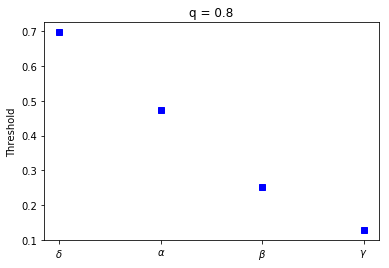

In [57]:
net.compute_coherence_thresholds(q = 0.8)

# Printing the threshold values 
print(r'Threshold in $\delta$ band = ' + str(net.coh_thr[0]))
print(r'Threshold in $\alpha$ band = ' + str(net.coh_thr[1]))
print(r'Threshold in $\beta$  band = ' + str(net.coh_thr[2]))
print(r'Threshold in $\gamma$ band = ' + str(net.coh_thr[3]))

plt.plot(range(4), net.coh_thr, 'bs')
plt.xticks(range(4), [r'$\delta$', r'$\alpha$', r'$\beta$', r'$\gamma$ '])
plt.title('q = 0.8')
plt.ylabel('Threshold')
plt.savefig('figures/layerwise_net/thresholds_q80.png')

To better visualize the threshold we can plot the pooled ditributions of coherence for each frequency band and indicate the threshold with a vertical line:

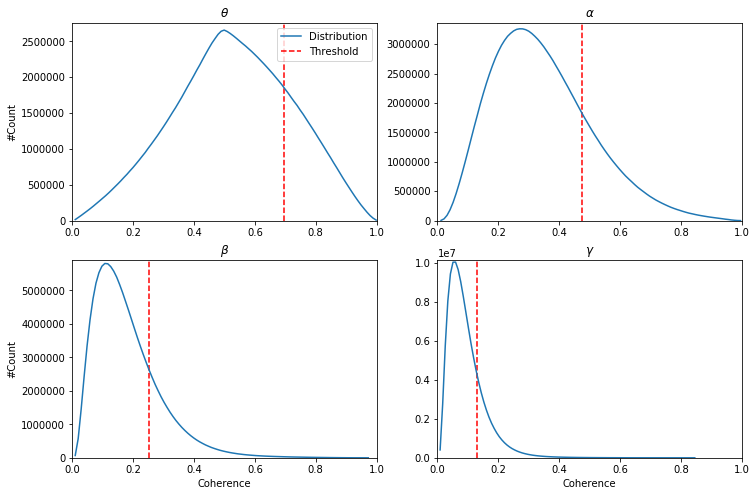

In [58]:
plot_pooled_coherence_dists(net.super_tensor, bins = 100, 
                            normed = False, 
                            thrs = [net.coh_thr[0], net.coh_thr[1], 
                                    net.coh_thr[2], net.coh_thr[3]],
                            titles = bands, figsize=(12,8))
plt.savefig('figures/layerwise_net/super_tensor_dists_thr.png')

Let's plot the binarized super tensor as well:

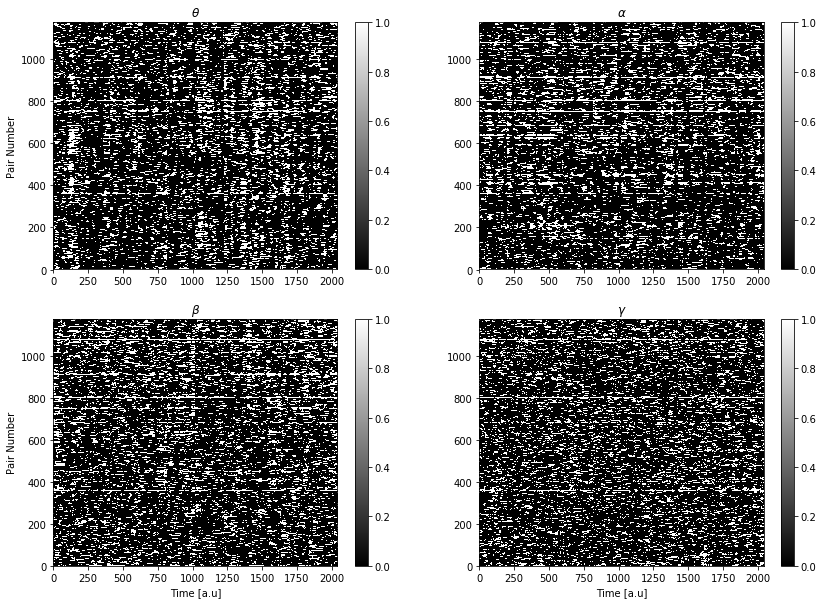

In [59]:
plot_nodes_raster_all_bands(net.super_tensor[:,:,:10*len(net.tarray)], 
                            0, 10*len(net.tarray), 
                            1, net.session_info['nP'], 0, 1, 
                            'Pair Number', 'Time [a.u]', bands, (14,10), 'gray',
                            thrs = [net.coh_thr[0], net.coh_thr[1], 
                                    net.coh_thr[2], net.coh_thr[3]],)
plt.savefig('figures/layerwise_net/super_tensor_thresholded.png')

To use the Python package networkx or igraph to compute network theory quantities it is necessary to instantiate a __Graph__ object, to do so we have to provide an adjacency matrix to the __Graph__ method. Note that the super tensor is the edge representation of the network, but we can convert it to an adjacency matrix by calling the methdo __convert_to_adjacency__ in the class __temporal_network__. This method will create the variable __A__ inside the object.

In [60]:
net.convert_to_adjacency()

The adjacency matrix has dimensions [Number of channels, Number of channels Number of frequency bands, Number of trials * Time]. Let's plot both the weighted and binary adjancency matrix for the 10th observation (or time stamp) of the alpha band.

Text(0.5, 1.0, 'Binarized, $\\alpha$ band, observation 10')

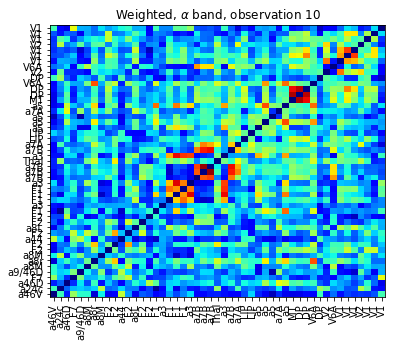

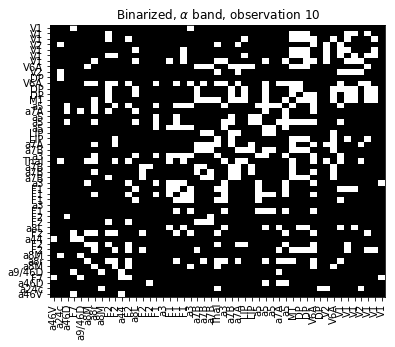

In [11]:
plot_adjacency(net.A[:,:,1,10], net.session_info['areas'], 'jet', (6,5))
plt.title(r'Weighted, $\alpha$ band, observation 10')
plot_adjacency(net.A[:,:,1,10]>net.coh_thr[1], net.session_info['areas'], 'gray', (6,5))
plt.title(r'Binarized, $\alpha$ band, observation 10')

Before moving the measures and preliminary results, during the analysis we may be interested to separate the measures we make by task stage, to do so we need some way to acess our arrays (super_tensor, adjacency matrix, node_degree...) in an specific stage. Using the method __create_stages_time_grid__, four array will be created inside the object: __t_baseline__, __t_cue__, __t_delay__, and __t_match__. Using those array any stage can be acessed easily, let's suposse you want the super tensor values only for the delay period in alpha band, you can retrieve this values by doing:

```net.super_tensor[:,1,net.t_baseline] ```

In [12]:
# Creating stages grid
net.create_stages_time_grid()

Now let's plot for each trial the duration of each period

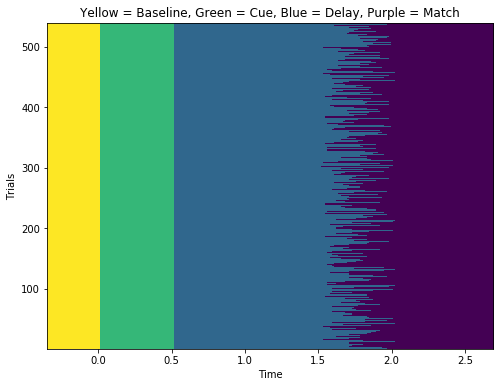

In [61]:
stages = np.zeros([net.session_info['nT'],len(net.tarray)])
ii     = [net.t_baseline.reshape(net.session_info['nT'],len(net.tarray)), 
          net.t_cue.reshape(net.session_info['nT'],len(net.tarray)), 
          net.t_delay.reshape(net.session_info['nT'],len(net.tarray)),
          net.t_match.reshape(net.session_info['nT'],len(net.tarray))]
for i in range(4):
    stages = stages - i * ii[i]
    
plt.figure(figsize = (8,6))
plt.imshow(stages, aspect='auto',cmap='viridis',origin='lower', extent=[net.tarray[0],net.tarray[-1],1,540])
plt.ylabel('Trials')
plt.xlabel('Time')
plt.title('Yellow = Baseline, Green = Cue, Blue = Delay, Purple = Match')
plt.savefig('figures/layerwise_net/stages.png')

Similarly to separating the measurements by task stage, we could be insterested in separating them by cue type (i.e., by differenciating the cue presented to the monkey), to create the grid which allows us to acess trials were a specific cue was presented to the monkey the method __create_stim_grid__. This method will create an array named __stim_grid__ inside the __temporal_network__ object, this array will have the shape [Number of cues, Trials * Time]. Let's suposse you want the super tensor values in the alpha band only for the second cue type presented, you can retrieve this values by doing:

```net.super_tensor[:,1,net.stim_grid[1]] ```

In [62]:
net.create_stim_grid()

We can now visualize, for instance, which trials received each cue type (for the first 20 trials):

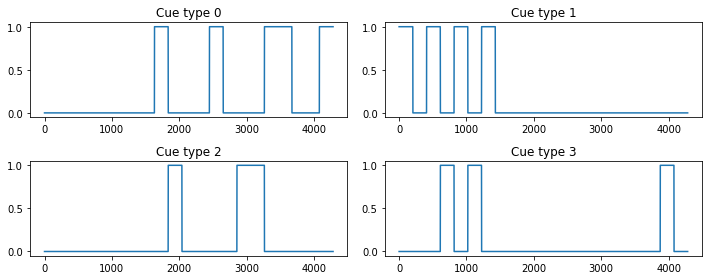

In [63]:
plt.figure(figsize=(10,4))
for i in range(net.stim_grid.shape[0]-1):
    plt.subplot(2,2,i+1)
    plt.plot(net.stim_grid[i,:21*len(net.tarray)])
    plt.title('Cue type ' + str(i))
plt.tight_layout()

Finally, since the results for the binarized network will depend on the threshold choice it is important to study the fraction of retained links as a function of $q$ for each band and task stage.

In [65]:
# Values of q used
q_list     = np.linspace(0.2, 0.9, 10)
n_retained = np.zeros([len(q_list), len(net.bands), 4]) # [Values of q, Number of bands, Number of stages]
# Computing the threshold for the specific q value
for i in tqdm( range( len( q_list) ) ):
    net.compute_coherence_thresholds(q = q_list[i])
    for j in range( len(net.bands) ):
        # Binary super tensor
        bst               = net.super_tensor[:,j,:] > net.coh_thr[j]
        n_retained[i,j,0] = bst[:,net.t_baseline].sum() / (net.session_info['nP'] * net.t_baseline.sum())
        n_retained[i,j,1] = bst[:,net.t_cue].sum()      / (net.session_info['nP'] * net.t_cue.sum())
        n_retained[i,j,2] = bst[:,net.t_delay].sum()    / (net.session_info['nP'] * net.t_delay.sum())
        n_retained[i,j,3] = bst[:,net.t_match].sum()    / (net.session_info['nP'] * net.t_match.sum())

# Set q to 0.80 again
net.compute_coherence_thresholds(q=.8)


100%|██████████| 10/10 [09:42<00:00, 58.25s/it]


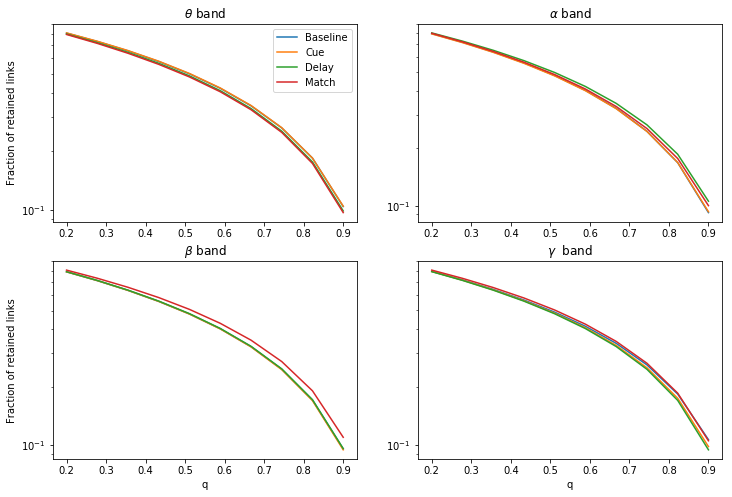

In [67]:
plt.figure(figsize=(12,8))
for j in range( len(net.bands) ):
    plt.subplot(2,2,j+1)
    plt.semilogy(q_list, n_retained[:,j,0], label = 'Baseline')
    plt.semilogy(q_list, n_retained[:,j,1], label = 'Cue')
    plt.semilogy(q_list, n_retained[:,j,2], label = 'Delay')
    plt.semilogy(q_list, n_retained[:,j,3], label = 'Match')
    plt.title(bands[j] + ' band')
    if j == 0:
        plt.legend()
    if j == 2 or j == 3:
        plt.xlabel('q')
    if j == 0 or j == 2:
        plt.ylabel('Fraction of retained links')
plt.savefig('figures/layerwise_net/fraction_reained_links.png')

### Analysing the dependece of coherence distributions on frequency, stage, and cue of link weights 

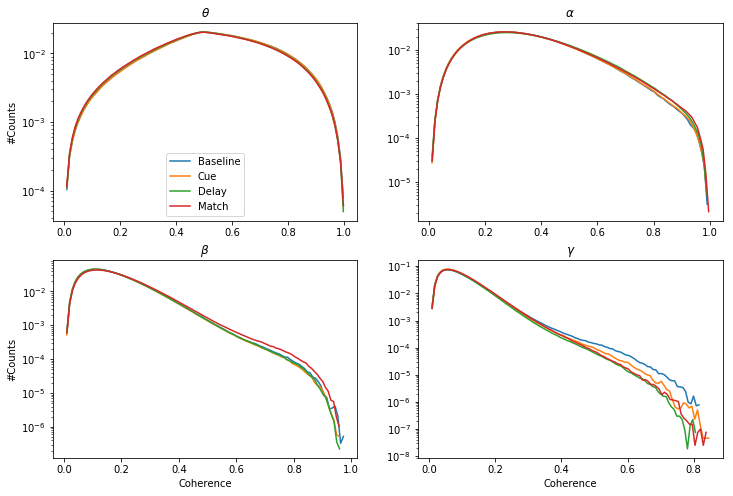

In [68]:
plot_pooled_coherence_dists_per_stage(net.super_tensor, 
                                      [net.t_baseline, net.t_cue, net.t_delay, net.t_match],
                                      bins = 100, normed = True, titles = bands, figsize=(12,8))
plt.savefig('figures/layerwise_net/pooled_st_dist_per_band.png')

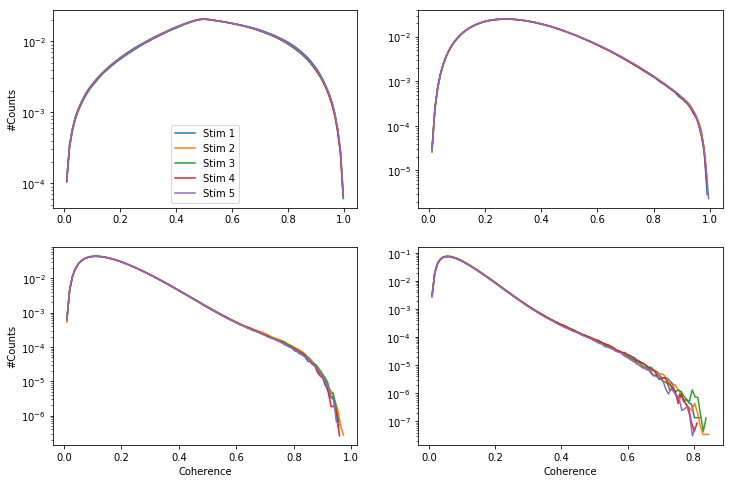

In [69]:
plot_pooled_coherence_dists_per_stim(net.super_tensor, 
                                      net.stim_grid,
                                      bins = 100, normed = True, titles = bands, figsize=(12,8))
plt.savefig('figures/layerwise_net/pooled_st_dist_per_cue.png')

### Null models and temporal correlations

It is possible to create null models for the adjacency matrix by using the method __create_null_model__, it i possible to create a null model by randomizing the edges by setting the parameter __randomize='edges'__, or by permuting the time layers by setting __randomize='time'__. The adjacency matrix for the null model is stored on the variable __A_null__. After creating the null models we can compare, for instance, compute the temporal correlation of the adjacency matrices for the original network and the randomized ones using the function __compute_temporal_correlation__.

In [16]:
CC_re = np.zeros(10) # Randomized edges
CC_rt = np.zeros(10) # Randomized layers
# Original network
CC_on = net.compute_temporal_correlation(band = 1, thr = net.coh_thr[1], tau = 1, on_null = False)
for i in tqdm( range(10) ):
    # Randomize on edges
    CC_re[i] = net.compute_temporal_correlation(band = 1, thr = net.coh_thr[1], tau = 1, 
                                                on_null = True, randomize = 'edges', seed = i)
    # Randomize on time
    CC_rt[i] = net.compute_temporal_correlation(band = 1, thr = net.coh_thr[1], tau = 1, 
                                                on_null = True, randomize='time', seed = i * 10)

/home/vinicius/GrayData-Analysis/GDa/temporal_network.py:335: RuntimeWarning: invalid value encountered in true_divide
  Ci  = np.nansum(( num / den ), axis=1) / (A.shape[-1] - 1)
100%|██████████| 10/10 [04:10<00:00, 25.02s/it]


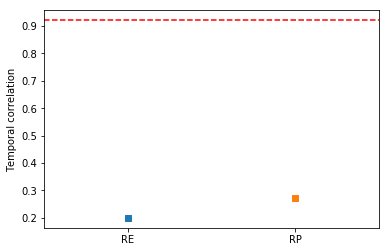

In [70]:
plt.errorbar(1, CC_re.mean(), CC_re.std(), marker='s')
plt.errorbar(3, CC_rt.mean(), CC_rt.std(), marker='s')
plt.hlines(CC_on, 0, 4, linestyle='--', color = 'r')
plt.xlim([0,4])
plt.ylabel('Temporal correlation')
plt.xticks([1,3], ['RE', 'RP'])
plt.savefig('figures/layerwise_net/temp_corr_re_rp.png')

### Node strength/degree

Next we can compute a few network measures in the data, as a general rule if the parameter __thr__ is set to __None__ in those methods the weighted version of the measure will be computed (networkx), and the binarized (networkx or igraph) otherwise. 

Let's start by computing the node strength/degree using the method __compute_nodes_degree__.


__OBSERVATION__: Since computing node strength/degree is straightfoward, once the adjacency matrix are in hand the method __compute_nodes_degree__ does not rely on networkx.

In [71]:
# Computing node strength for each band
st_delta = net.compute_nodes_degree(0, thr = None)
st_alpha = net.compute_nodes_degree(1, thr = None)
st_beta  = net.compute_nodes_degree(2, thr = None)
st_gamma = net.compute_nodes_degree(3, thr = None)
#
st = np.array([st_delta, st_alpha, st_beta, st_gamma])
st = np.swapaxes(st, 0,1)

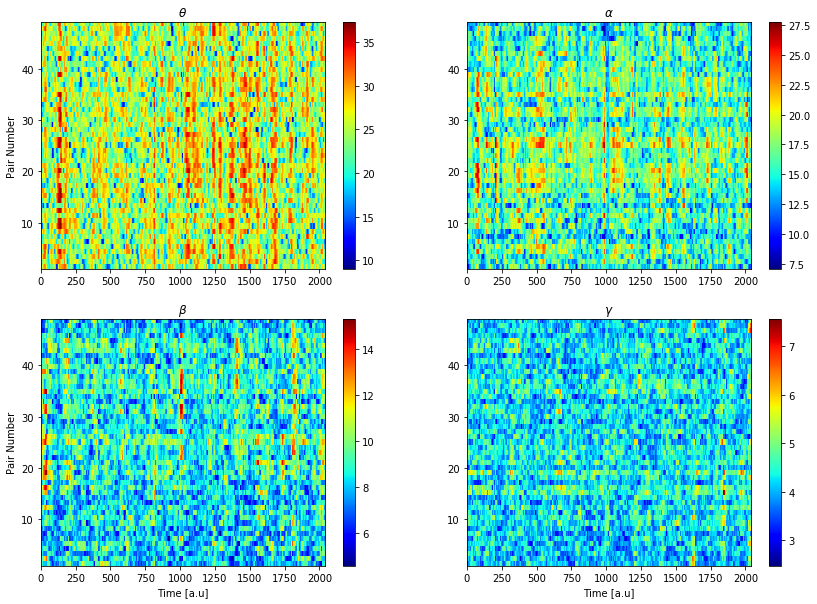

In [72]:
plot_nodes_raster_all_bands(st[:,:,:10*len(net.tarray)], 
                            0, 10*len(net.tarray), 
                            1, net.session_info['nC'], None, None, 
                            'Pair Number', 'Time [a.u]', bands, (14,10), 'jet')
plt.savefig('figures/layerwise_net/raster_strength.png')

In [73]:
# Computing node degree for each band
dg_delta = net.compute_nodes_degree(0, thr = net.coh_thr[0])
dg_alpha = net.compute_nodes_degree(1, thr = net.coh_thr[1])
dg_beta  = net.compute_nodes_degree(2, thr = net.coh_thr[2])
dg_gamma = net.compute_nodes_degree(3, thr = net.coh_thr[3])
#
dg = np.array([dg_delta, dg_alpha, dg_beta, dg_gamma])
dg = np.swapaxes(dg, 0,1)

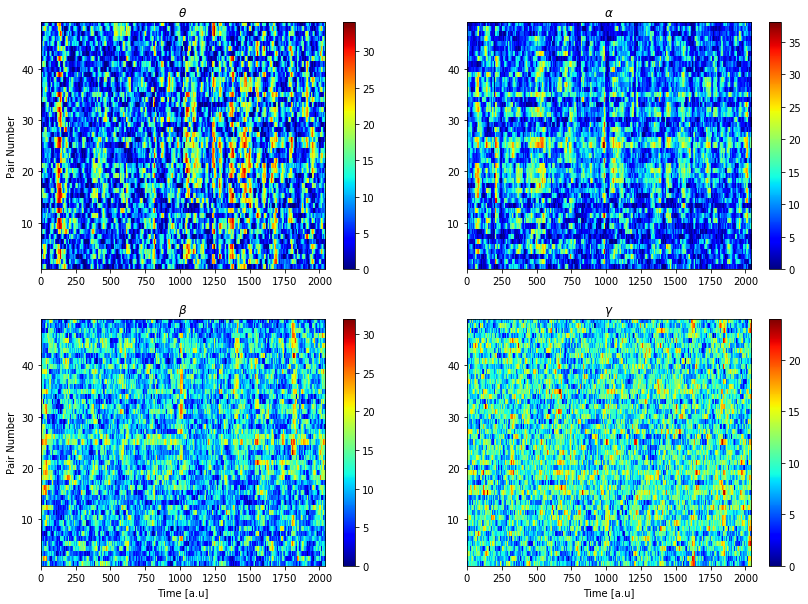

In [74]:
plot_nodes_raster_all_bands(dg[:,:,:10*len(net.tarray)], 
                            0, 10*len(net.tarray), 
                            1, net.session_info['nC'], None, None, 
                            'Pair Number', 'Time [a.u]', bands, (14,10), 'jet')
plt.savefig('figures/layerwise_net/raster_degree.png')

It is hard to compare both the weighted and binary version of the measure by means of the raster plot, however we can measure the summed strength/degree of the network for a more general view. Let's plot the summed node strength/degree for the alpha band, as well as the summed node strength/degree over trials for both weighted (blue plots) and binary (red plots) network.

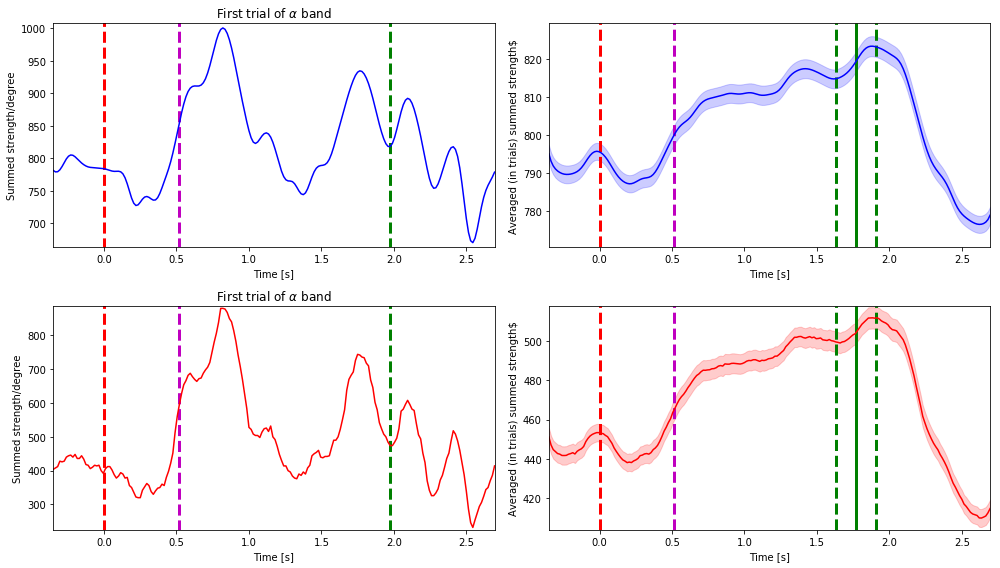

In [75]:
plt.figure(figsize=(14,8))
for i in range(2):
    if i == 0:
        c = 'b'
    else:
        c = 'r'
    p1 = 1 + i*2
    p2 = 2 + i*2
    plt.subplot(2,2,p1)
    if i == 0:
        s_d_w = st_alpha[:,:len(net.tarray)].sum(axis = 0)
    else:
        s_d_w = dg_alpha[:,:len(net.tarray)].sum(axis = 0)
    plt.plot(net.tarray, s_d_w, color = c)
    plt.ylim([s_d_w.min()-7, s_d_w.max()+7])
    plt.xlim([net.tarray[0],net.tarray[-1]])
    plt.vlines(0, s_d_w.min()-10, s_d_w.max()+10, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off'][0]-net.session_info['t_cue_on'][0])/1000, 
               s_d_w.min()-10, s_d_w.max()+10, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on'][0]-net.session_info['t_cue_on'][0])/1000, 
               s_d_w.min()-10, s_d_w.max()+10, linestyle='--', linewidth = 3, color = 'g')
    plt.title(r'First trial of $\alpha$ band')
    plt.xlabel('Time [s]')
    plt.ylabel('Summed strength/degree')
    plt.subplot(2,2,p2)
    if i == 0:
        s_d = st_alpha.sum(axis=0)
    else:
        s_d = dg_alpha.sum(axis=0)
    s_d = s_d.reshape(540,len(net.tarray))
    s_d_m = s_d.mean(axis = 0)
    s_d_e = s_d.std(axis = 0) / (s_d.shape[0]**0.5)
    s_d_m = s_d_m
    s_d_e = s_d_e
    plt.plot(net.tarray, s_d_m, color = c)
    plt.fill_between(net.tarray, s_d_m-s_d_e, s_d_m+s_d_e, alpha = .2, color = c)
    plt.xlim([net.tarray[0],net.tarray[-1]])
    plt.ylim([s_d_m.min()-6, s_d_m.max()+6])
    plt.vlines(0, s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
               s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='-', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'g')
    plt.ylabel('Averaged (in trials) summed strength$')
    plt.xlabel('Time [s]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/strength_first_trial.png')

Next, we can analyse the summed strength avareged on trials for each frequency band as well:

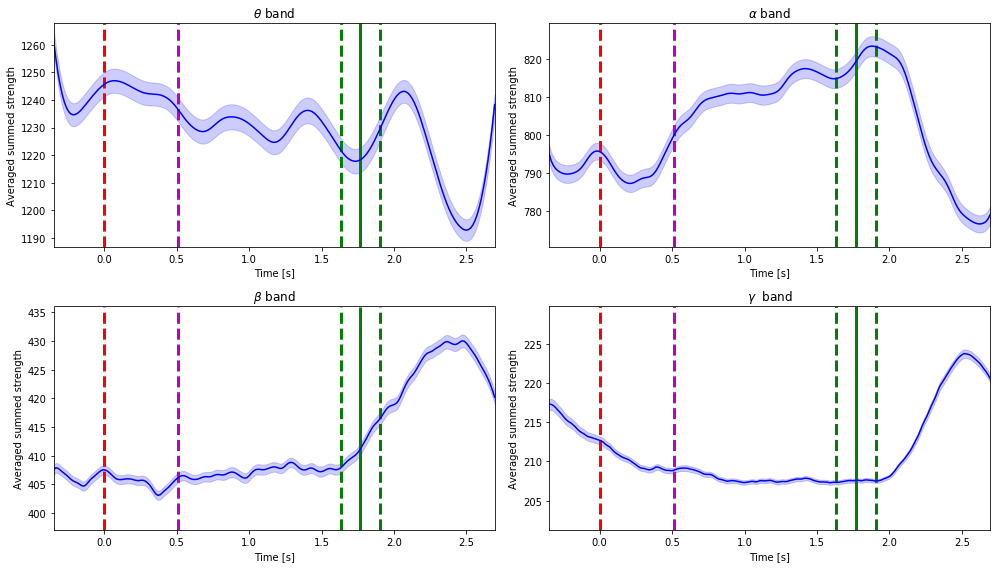

In [76]:
plt.figure(figsize=(14,8))
c = ['b', 'r']
for j in range( len(net.bands) ):
    plt.subplot(2,2,j+1)
    # Original
    s_d = st[:,j,:].sum(axis=0)
    s_d = s_d.reshape(540,len(net.tarray))
    s_d_m = s_d.mean(axis = 0)
    s_d_e = s_d.std(axis = 0) / (s_d.shape[0]**0.5)
    #
    plt.plot(net.tarray, s_d_m, color = 'b')
    plt.fill_between(net.tarray, s_d_m-s_d_e, s_d_m+s_d_e, alpha = .2, color = 'b')
    #
    plt.title(bands[j] + ' band')
    plt.xlim([net.tarray[0],net.tarray[-1]])
    plt.ylim([s_d_m.min()-6, s_d_m.max()+6])
    plt.vlines(0, s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                   s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='-', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'g')
    plt.ylabel('Averaged summed strength')
    plt.xlabel('Time [s]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/summed_strength.png')

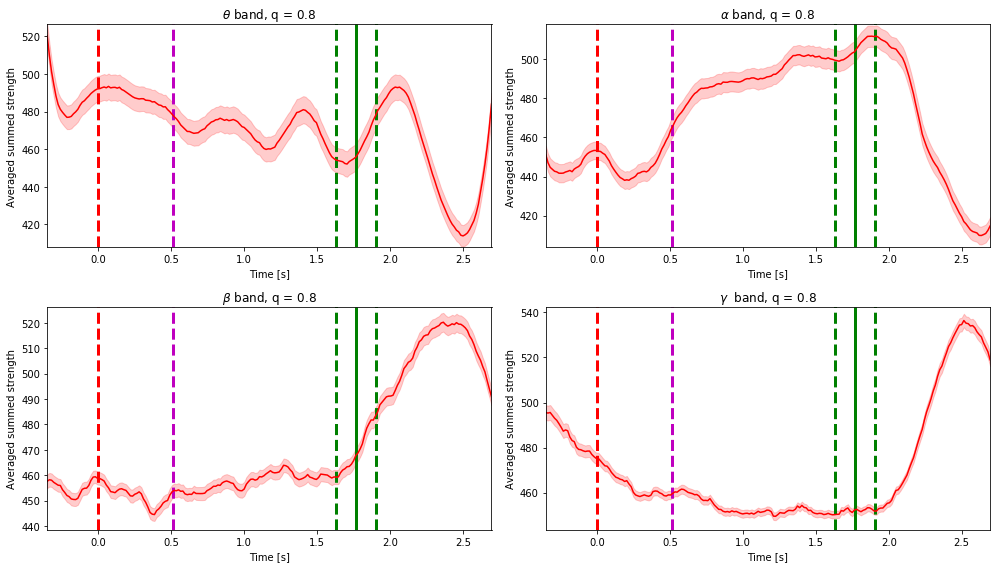

In [77]:
plt.figure(figsize=(14,8))
c = ['b', 'r']
for j in range( len(net.bands) ):
    plt.subplot(2,2,j+1)
    if j == 0: s_d = dg_delta.sum(axis=0)
    if j == 1: s_d = dg_alpha.sum(axis=0)
    if j == 2: s_d = dg_beta.sum(axis=0)
    if j == 3: s_d = dg_gamma.sum(axis=0)
    s_d = s_d.reshape(540,len(net.tarray))
    s_d_m = s_d.mean(axis = 0)
    s_d_e = s_d.std(axis = 0) / (s_d.shape[0]**0.5)
    plt.plot(net.tarray, s_d_m, color = 'r')
    plt.fill_between(net.tarray, s_d_m-s_d_e, s_d_m+s_d_e, alpha = .2, color='r')
    plt.title(bands[j] + ' band, q = 0.8')
    plt.xlim([net.tarray[0],net.tarray[-1]])
    plt.ylim([s_d_m.min()-6, s_d_m.max()+6])
    plt.vlines(0, s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                   s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='-', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+8, linestyle='--', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+8, linestyle='--', linewidth = 3, color = 'g')
    plt.ylabel('Averaged summed strength')
    plt.xlabel('Time [s]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/summed_degree.png')

Last but not least, we can instead of average over all trials take the average by trials that the same cue was applied:

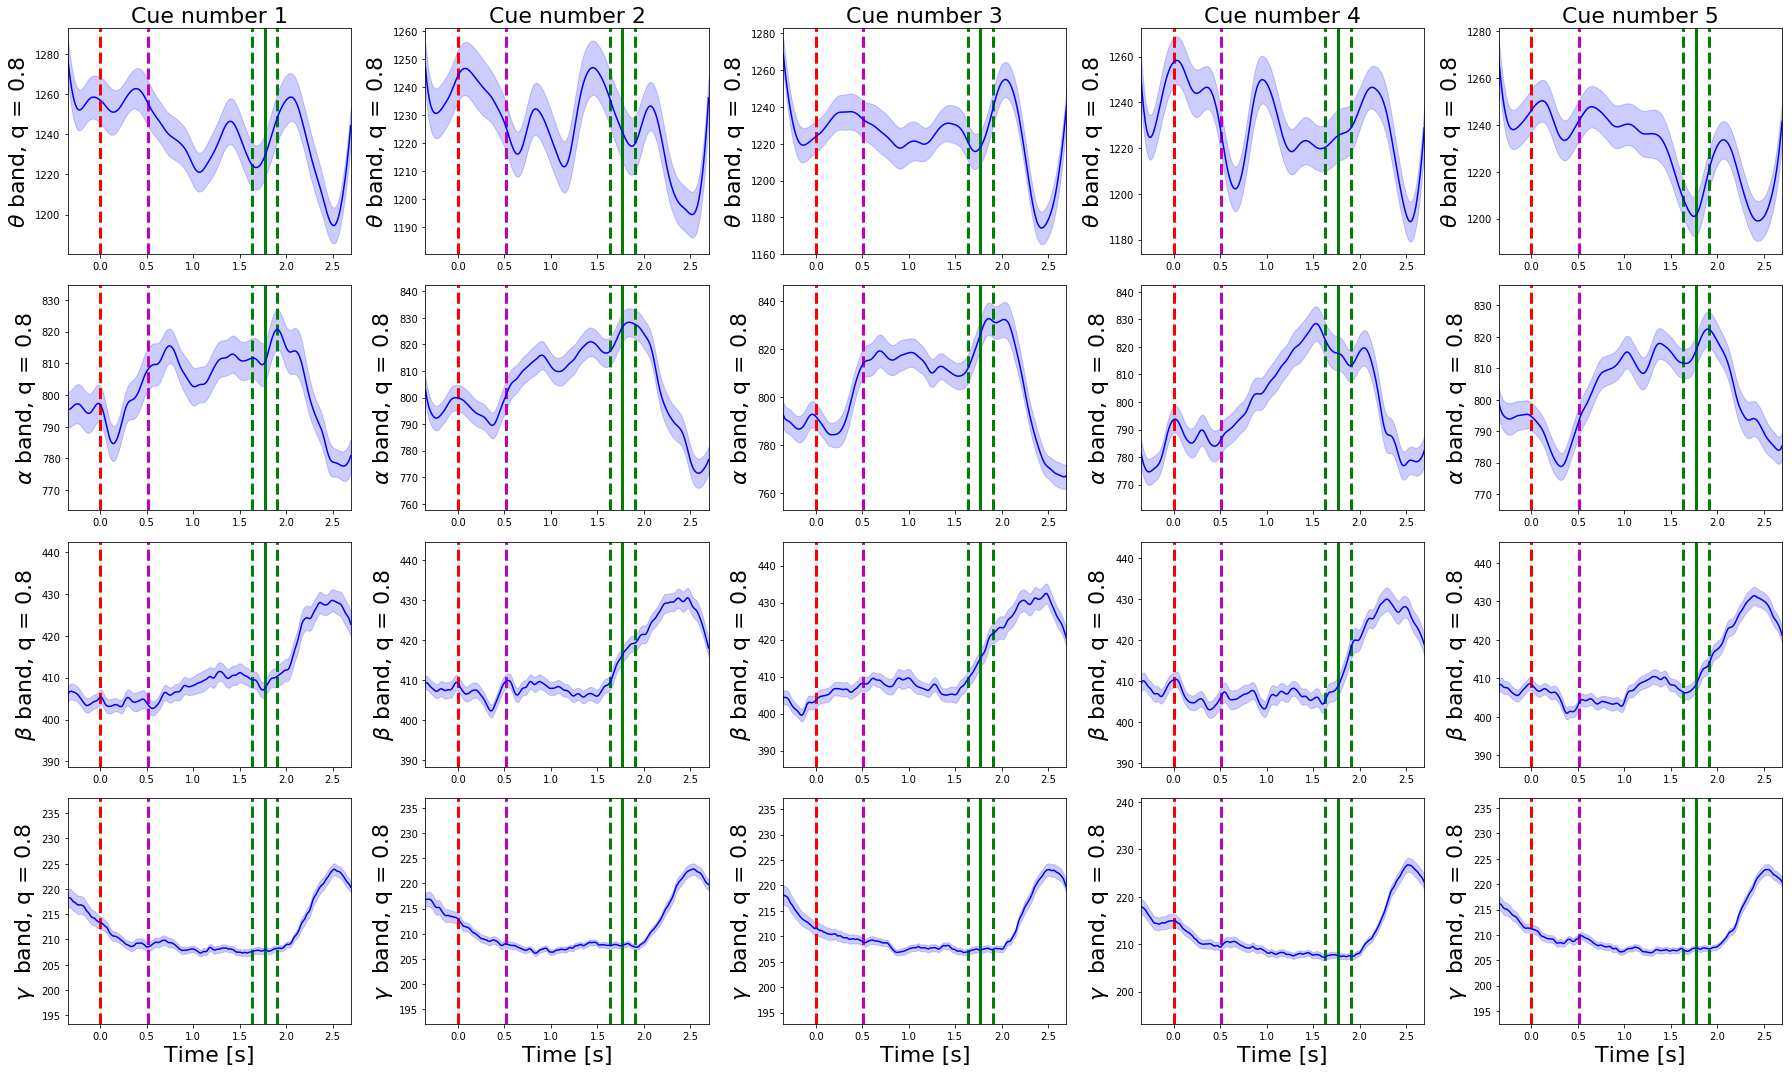

In [78]:
idx = 1
plt.figure(figsize=(25,15))
for i in range( len(net.bands) ):
    for j in range( net.stim_grid.shape[0] ):
        # Computing average over trials for specific cue number
        nt  = np.sum(net.session_info['stim']==j)
        if i == 0: s_d = st_delta.sum(axis=0)
        if i == 1: s_d = st_alpha.sum(axis=0)
        if i == 2: s_d = st_beta.sum(axis=0)
        if i == 3: s_d = st_gamma.sum(axis=0)
        s_d = s_d[net.stim_grid[j].astype(bool)].reshape(nt, len(net.tarray))
        s_d_m = s_d.mean(axis = 0)
        s_d_e = s_d.std(axis = 0) / (s_d.shape[0]**0.5)
        # plot
        plt.subplot( len(net.bands), net.stim_grid.shape[0], idx)
        plt.plot(net.tarray, s_d_m, color = 'b')
        plt.fill_between(net.tarray, s_d_m-s_d_e, s_d_m+s_d_e, alpha = .2, color='b')
        plt.xlim([net.tarray[0],net.tarray[-1]])
        plt.ylim([s_d_m.min()-14, s_d_m.max()+14])
        plt.vlines(0, s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'r')
        plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                   s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'm')
        plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-14, s_d_m.max()+14, linestyle='-', linewidth = 3, color = 'g')
        plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'g')
        plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'g')
        plt.ylabel(bands[i] + ' band, q = 0.8', fontsize=22)
        idx += 1
        if i == 0:
            plt.title('Cue number ' + str(j+1), fontsize=22)
        if i == 3:
            plt.xlabel('Time [s]', fontsize=22)
plt.tight_layout()
plt.savefig('figures/layerwise_net/summed_degree_bands_cue.png')

### Correlation between strength and degree as a function of threshold

In [21]:
q_list= np.linspace(0.2, 0.9, 10)
cc_ns = np.zeros([len(q_list), len(net.bands) ])
for i in tqdm (range( len(q_list) )):
    net.compute_coherence_thresholds(q = q_list[i])
    for j in range( len(net.bands) ):
        # Degree
        degree   = net.compute_nodes_degree(j, thr = net.coh_thr[j]).sum(axis = 0)
        # Strength
        strength = net.compute_nodes_degree(j, thr = None).sum(axis = 0)
        # Correlation
        cc_ns[i,j] = np.corrcoef(strength, degree)[0,1]


100%|██████████| 10/10 [11:01<00:00, 66.17s/it]


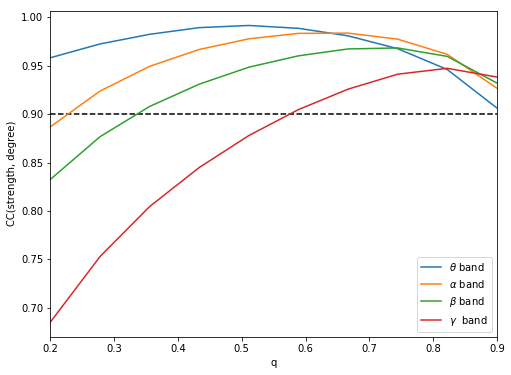

In [79]:
plt.figure(figsize=(8,6))
for j in range( len(net.bands) ):
    plt.plot(q_list, cc_ns[:,j], label = bands[j] + ' band')
    plt.ylabel('CC(strength, degree)')
    plt.xlabel('q')
plt.xlim([0.2,0.9])
plt.hlines(0.90,0.2,0.9, linestyle = '--', color = 'k')
plt.legend()
plt.savefig('figures/layerwise_net/cc_st_dg.png')

In [80]:
# Put threshold back to q = 0.8
net.compute_coherence_thresholds(q = 0.8)

### Randomized networks preserving degree

To create the random network the method __create_null_model__, it will create a randomized version of the adjacency matrix A in a given band seted by the parameter __band__, the parameter __randomize__ can be set either as __edges__ or __time__, in the first case the edges for each node will be randomized for each layer, in the latter the frames of the temporal netowork will be randomly shuffled, you can also set the randomization seed using the parameter __seed__. 

You can compute the network quantities in the null model by setting the parameter __on_null__ equals __True__ in the method for each measurement. Let's plot the degree of the randomized vs. the original network for each band (without error bars for better visualization).


In [81]:
st_random = np.zeros([net.A.shape[0], len(net.bands),  net.A.shape[-1]])
for i in range(len(net.bands)):
    st_random[:,i,:] = net.compute_nodes_degree(band = i, thr = net.coh_thr[i], on_null = True, randomize='edges', seed = 0)

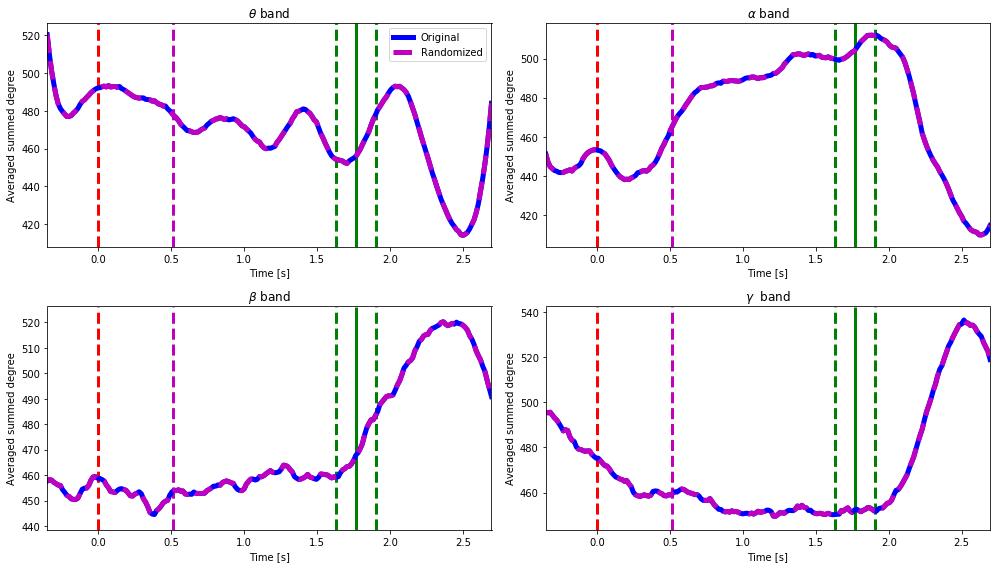

In [83]:
plt.figure(figsize=(14,8))
for j in range( len(net.bands) ):
    plt.subplot(2,2,j+1)
    # Original
    s_d = dg[:,j,:].sum(axis=0)
    s_d = s_d.reshape(540,len(net.tarray))
    s_d_m = s_d.mean(axis = 0)
    #
    plt.plot(net.tarray, s_d_m, 'b', lw=5)
    # Random
    s_d = st_random[:,j,:].sum(axis=0)
    s_d = s_d.reshape(540,len(net.tarray))
    s_d_m = s_d.mean(axis = 0)
    #
    plt.plot(net.tarray, s_d_m, 'm--', lw=5)
    if j == 0:
        plt.legend(['Original', 'Randomized'])
    plt.title(bands[j] + ' band')
    plt.xlim([net.tarray[0],net.tarray[-1]])
    plt.ylim([s_d_m.min()-6, s_d_m.max()+6])
    plt.vlines(0, s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                   s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='-', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'g')
    plt.ylabel('Averaged summed degree')
    plt.xlabel('Time [s]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/strength_random_edges.png')

To compute a given network statistics for more than one randomization, the method __net.compute_null_statistics__ can be used. It takes as arguments the name of the method relative to the desired statistics (e.g., __net.compute_nodes_degrees__), the number of different randomizations to take into consideration __n_stat__, and the parameters that shoudl be passes to the method given as first argument.

### Coreness 

The analysis below are all done for the binary network. First, we can do the same analysis measuring the k-coreness of the each node:

In [24]:
kc_delta = net.compute_nodes_coreness(band=0, thr=net.coh_thr[0], use='igraph')
kc_alpha = net.compute_nodes_coreness(band=1, thr=net.coh_thr[1], use='igraph')
kc_beta  = net.compute_nodes_coreness(band=2, thr=net.coh_thr[2], use='igraph')
kc_gamma = net.compute_nodes_coreness(band=3, thr=net.coh_thr[3], use='igraph')


 14%|█▍        | 15604/110160 [00:14<01:28, 1067.39it/s]


 29%|██▊       | 31466/110160 [00:29<01:08, 1143.45it/s]


 43%|████▎     | 47015/110160 [00:43<01:00, 1048.51it/s]


 57%|█████▋    | 62832/110160 [00:58<00:48, 983.07it/s] 


 71%|███████   | 78381/110160 [01:12<00:27, 1135.94it/s]


 85%|████████▌ | 93855/110160 [01:26<00:15, 1053.27it/s]


 99%|█████████▉| 109382/110160 [01:41<00:00, 1123.71it/s]


100%|██████████| 110160/110160 [01:42<00:00, 1079.97it/s]

 14%|█▎        | 14897/110160 [00:13<01:26, 1099.20it/s]


 28%|██▊       | 30308/110160 [00:27<01:17, 1027.71it/s]


 42%|████▏     | 45764/110160 [00:42<01:03, 1010.25it/s]


 56%|█████▌    | 61250/110160 [00:56<00:46, 1041.80it/s]


 70%|██████▉   | 77009/110160 [01:10<00:31, 1067.18it/s]


 84%|████████▍ | 92822/110160 [01:25<00:15, 1112.01it/s]


 99%|█████████▊| 108650/110160 [01:39<00:01, 1153.05it/s]


100%|██████████| 110160/110160 [01:40<00:00, 1095.88it/s]

 12%|█▏        | 13685/110160 [00:12<01:27, 1101.75it/s]


 26%|██▌       | 28733/110160 [00:26<01:16, 1070.46it/s]


 40%|████      | 44090/110160 [00:40<01:00, 1090.51it/s]


 54%|█████▍    | 59541/110160 [00:54<00:46, 1083.70it/s]


 68%|██████▊   | 74763/110160 [01:08<00:33, 1063.48it/s]


 82%|████████▏ | 89960/110160 [01:22<00:18, 1083.38it/s]


 96%|█████████▌| 105394/110160 [01:36<00:04, 1119.98it/s]


100%|██████████| 110160/110160 [01:41<00:00, 1089.61it/s]

 10%|▉         | 10758/110160 [00:09<01:27, 1138.23it/s]


 24%|██▎       | 26120/110160 [00:23<01:15, 1115.86it/s]


 38%|███▊      | 41483/110160 [00:37<01:02, 1094.22it/s]


 52%|█████▏    | 56850/110160 [00:51<00:46, 1148.47it/s]


 65%|██████▌   | 71992/110160 [01:05<00:35, 1074.05it/s]


 79%|███████▉  | 87147/110160 [01:19<00:21, 1058.64it/s]


 93%|█████████▎| 102274/110160 [01:33<00:07, 1073.74it/s]


100%|██████████| 110160/110160 [01:40<00:00, 1094.96it/s]


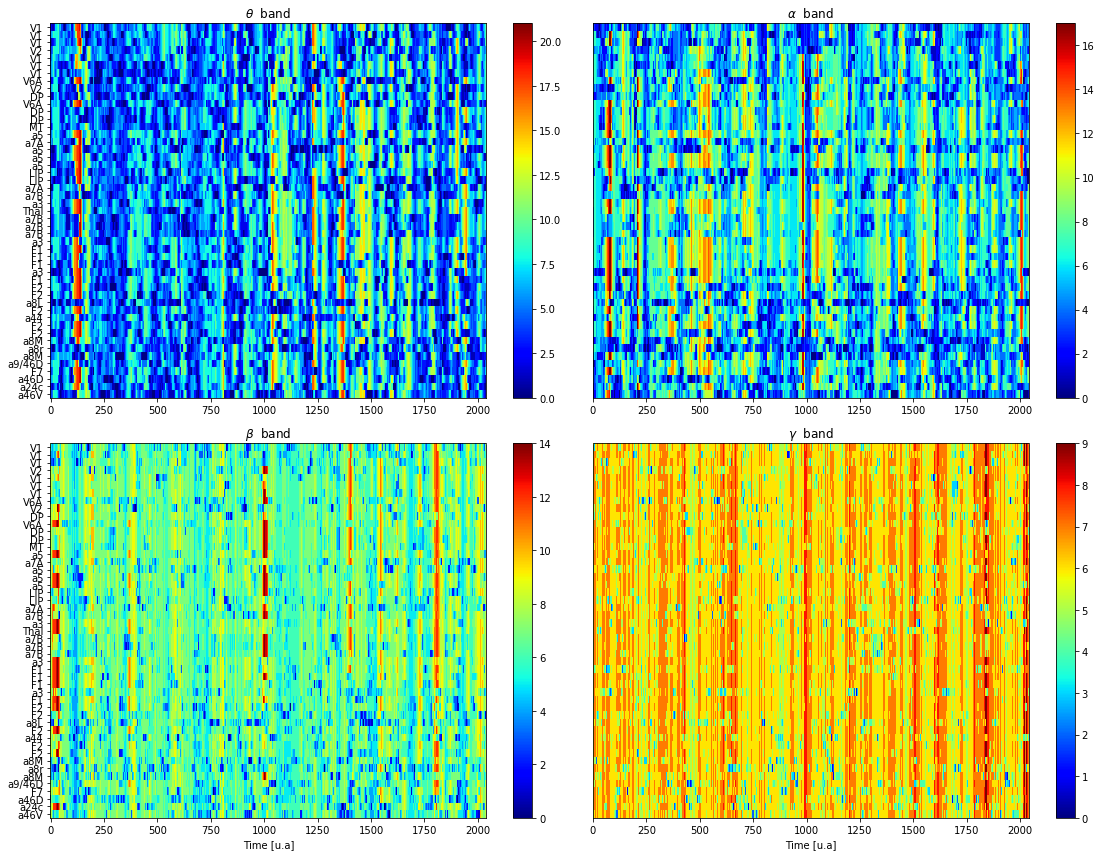

In [84]:
plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plt.imshow(kc_delta[:,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.yticks(range(49), net.session_info['areas'])
plt.title(r'$\theta$  band')
plt.subplot(2,2,2)
plt.imshow(kc_alpha[:,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.yticks([])
plt.title(r'$\alpha$  band')
plt.subplot(2,2,3)
plt.imshow(kc_beta[:,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.yticks(range(49), net.session_info['areas'])
plt.title(r'$\beta$  band')
plt.xlabel('Time [u.a]')
plt.subplot(2,2,4)
plt.imshow(kc_gamma[:,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.yticks([])
plt.title(r'$\gamma$  band')
plt.xlabel('Time [u.a]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/raster_coreness.png')

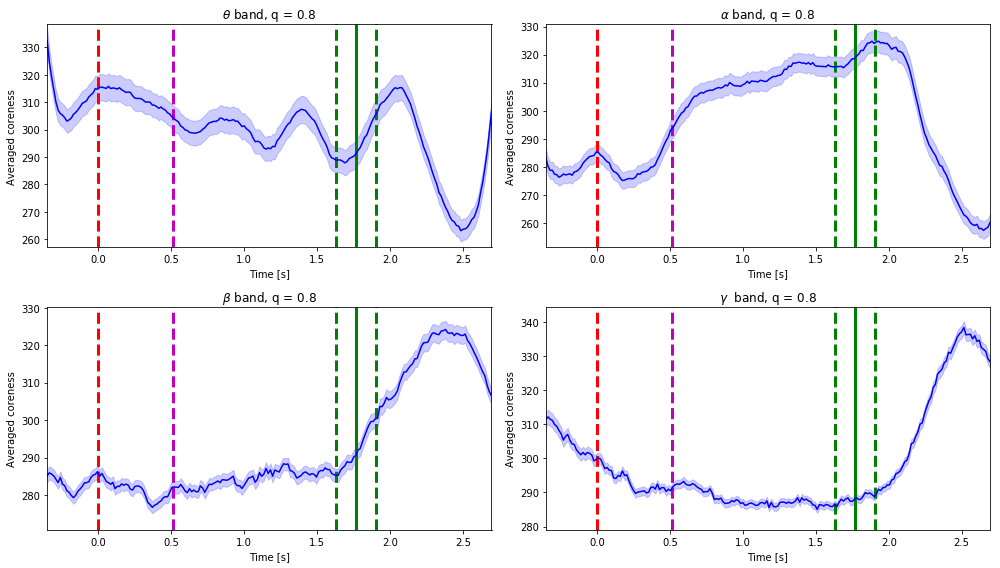

In [85]:
plt.figure(figsize=(14,8))
for j in range( len(net.bands) ):
    plt.subplot(2,2,j+1)
    if j == 0: s_d = kc_delta.sum(axis=0)
    if j == 1: s_d = kc_alpha.sum(axis=0)
    if j == 2: s_d = kc_beta.sum(axis=0)
    if j == 3: s_d = kc_gamma.sum(axis=0)
    #s_d = net.coreness[1,:,j,:].sum(axis=0)
    s_d = s_d.reshape(540,len(net.tarray))
    s_d_m = s_d.mean(axis = 0)
    s_d_e = s_d.std(axis = 0) / (s_d.shape[0]**0.5)
    plt.plot(net.tarray, s_d_m, color = 'b')
    plt.fill_between(net.tarray, s_d_m-s_d_e, s_d_m+s_d_e, color = 'b', alpha = .2)
    plt.title(bands[j] + ' band, q = 0.8')
    plt.xlim([net.tarray[0],net.tarray[-1]])
    plt.ylim([s_d_m.min()-6, s_d_m.max()+6])
    plt.vlines(0, s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='-', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+8, linestyle='--', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+8, linestyle='--', linewidth = 3, color = 'g')
    plt.ylabel('Averaged coreness')
    plt.xlabel('Time [s]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/summed_coreness.png')

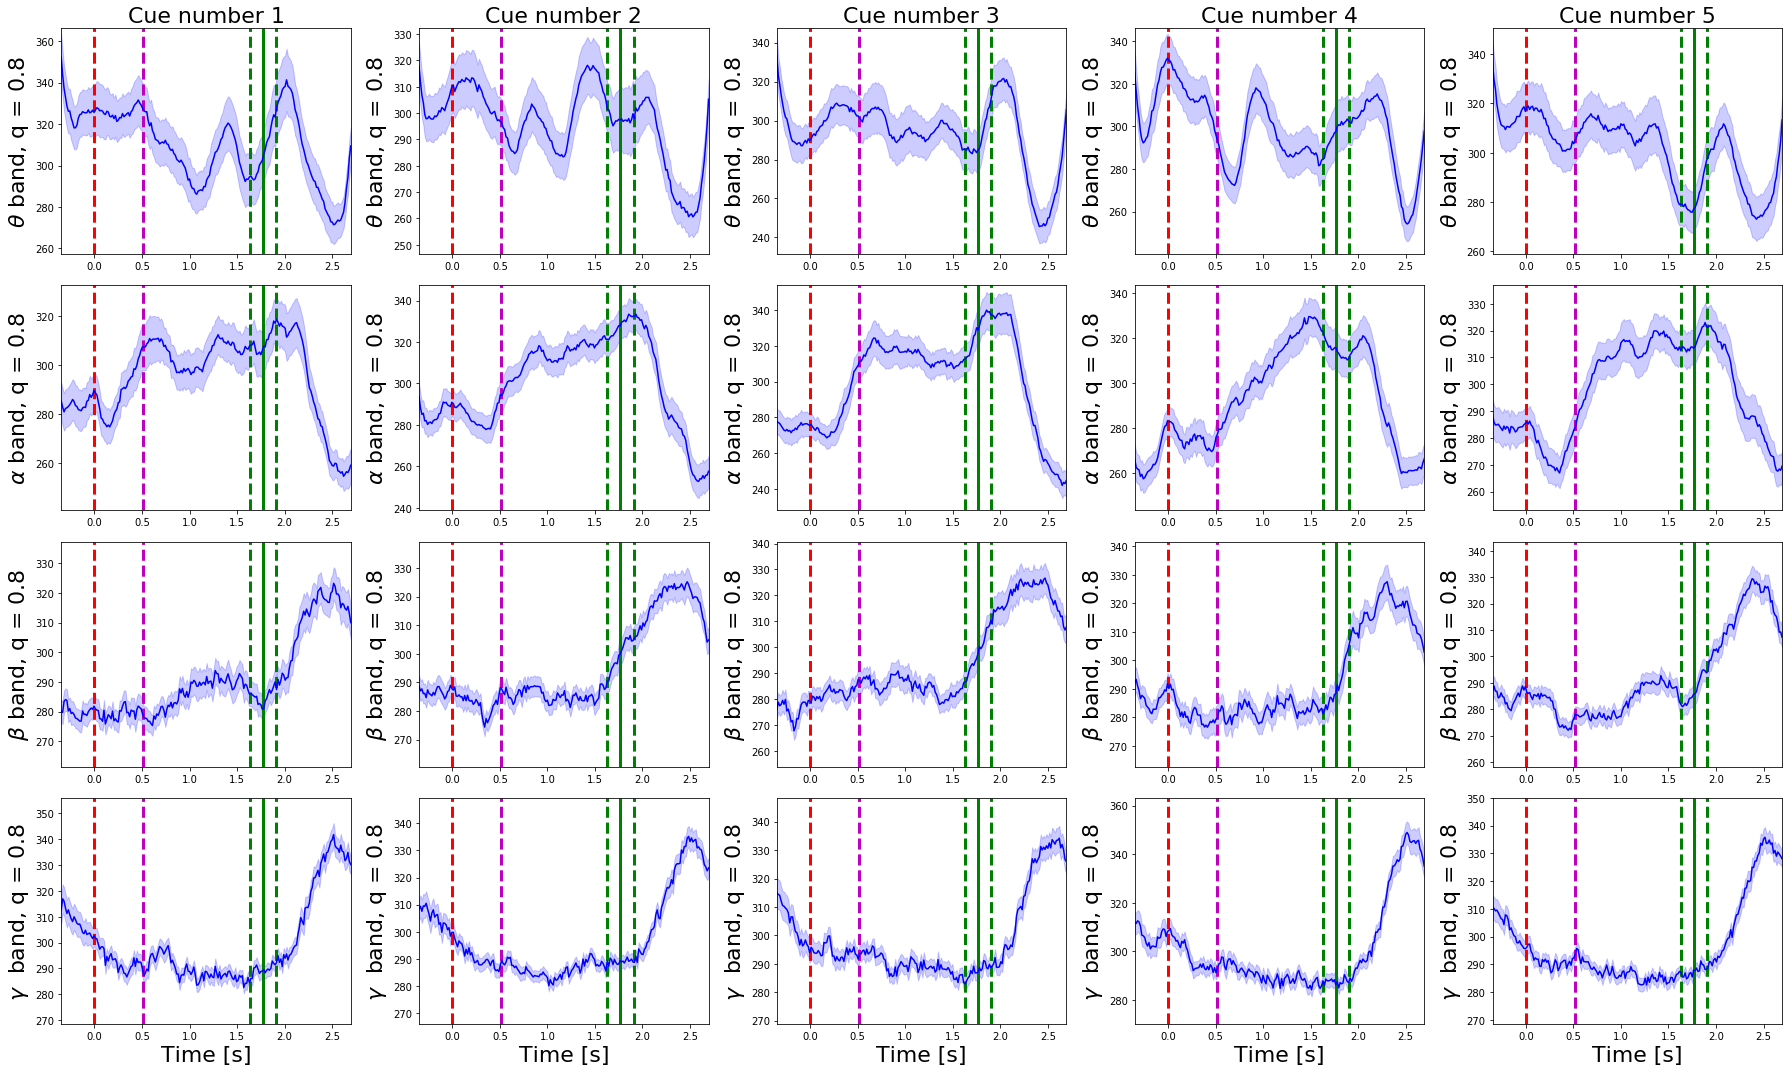

In [86]:
idx = 1
plt.figure(figsize=(25,15))
for i in range( len(net.bands) ):
    for j in range( net.stim_grid.shape[0] ):
        # Computing average over trials for specific cue number
        nt  = np.sum(net.session_info['stim']==j)
        if i == 0: s_d = kc_delta.sum(axis=0)
        if i == 1: s_d = kc_alpha.sum(axis=0)
        if i == 2: s_d = kc_beta.sum(axis=0)
        if i == 3: s_d = kc_gamma.sum(axis=0)
        #s_d = net.coreness[1,:,i,:].sum(axis=0)
        s_d = s_d[net.stim_grid[j].astype(bool)].reshape(nt, len(net.tarray))
        s_d_m = s_d.mean(axis = 0)
        s_d_e = s_d.std(axis = 0) / (s_d.shape[0]**0.5)
        # plot
        plt.subplot( len(net.bands), net.stim_grid.shape[0], idx)
        plt.plot(net.tarray, s_d_m, color = 'b')
        plt.fill_between(net.tarray, s_d_m-s_d_e, s_d_m+s_d_e, color = 'b', alpha = .2)
        plt.xlim([net.tarray[0],net.tarray[-1]])
        plt.ylim([s_d_m.min()-14, s_d_m.max()+14])
        plt.vlines(0, s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'r')
        plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                   s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'm')
        plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-14, s_d_m.max()+14, linestyle='-', linewidth = 3, color = 'g')
        plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'g')
        plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'g')
        plt.ylabel(bands[i] + ' band, q = 0.8', fontsize=22)
        idx += 1
        if i == 0:
            plt.title('Cue number ' + str(j+1), fontsize=22)
        if i == 3:
            plt.xlabel('Time [s]', fontsize=22)
plt.tight_layout()
plt.savefig('figures/layerwise_net/summed_coreness_bands_cue.png')

### Coreness - Chance level (alpha band)

In [28]:
start   = time.time()
kc_null = net.compute_null_statistics(net.compute_nodes_coreness, 10, band = 1, thr = net.coh_thr[1], 
                                      use='igraph', randomize = 'edges', 
                                      seed = 10, n_jobs=5)
end   = time.time()
print('Exc. time = ' + str((end-start)/60) + ' min.')

Exc. time = 8.015090310573578 min.


3
2


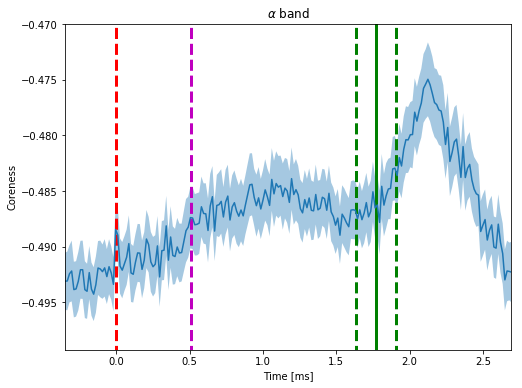

In [87]:
plt.figure(figsize=(8,6))
kc_null = np.array(kc_null)
# null model 
kc_nl = net.reshape_trials(kc_null).mean(axis=0).sum(axis=0)
# Original
kc_or = net.reshape_trials(kc_alpha).sum(axis=0) 
# Excess
E  = (kc_or - kc_nl) / kc_nl 
Em = E.mean(axis=0)
Es = 2*E.std(axis = 0) / np.sqrt(E.shape[0])
# Plot
plt.plot(net.tarray, Em)
plt.fill_between(net.tarray, Em-Es, Em+Es, alpha = .4)
plt.ylim([Em.min()-.005, Em.max()+.005])
plt.xlim([net.tarray[0], net.tarray[-1]])
plt.vlines(0, Em.min()-14, Em.max()+14, linestyle='--', linewidth = 3, color = 'r')
plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                   Em.min()-14, Em.max()+14, linestyle='--', linewidth = 3, color = 'm')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       Em.min()-14, Em.max()+14, linestyle='-', linewidth = 3, color = 'g')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       Em.min()-14, Em.max()+14, linestyle='--', linewidth = 3, color = 'g')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       Em.min()-14, Em.max()+14, linestyle='--', linewidth = 3, color = 'g')
plt.xlabel('Time [ms]')
plt.ylabel(r'Coreness')
plt.title(r'$\alpha$ band')
plt.savefig('figures/layerwise_net/excess_coreness.png')

### Clustering

Next we compute the clustering coefficient.

In [30]:
cl_delta = net.compute_nodes_clustering(band=0, thr=net.coh_thr[0], use='igraph')
cl_alpha = net.compute_nodes_clustering(band=1, thr=net.coh_thr[1], use='igraph')
cl_beta  = net.compute_nodes_clustering(band=2, thr=net.coh_thr[2], use='igraph')
cl_gamma = net.compute_nodes_clustering(band=3, thr=net.coh_thr[3], use='igraph')


 14%|█▎        | 15085/110160 [00:14<01:39, 951.43it/s]


 28%|██▊       | 30430/110160 [00:28<01:17, 1032.66it/s]


 41%|████▏     | 45568/110160 [00:43<00:59, 1092.75it/s]


 55%|█████▌    | 60931/110160 [00:57<00:45, 1086.32it/s]


 69%|██████▉   | 75864/110160 [01:11<00:32, 1052.68it/s]


 83%|████████▎ | 91034/110160 [01:26<00:17, 1105.07it/s]


 96%|█████████▌| 105906/110160 [01:40<00:04, 1002.60it/s]


100%|██████████| 110160/110160 [01:44<00:00, 1049.65it/s]

 10%|▉         | 10792/110160 [00:10<01:36, 1034.71it/s]


 23%|██▎       | 25566/110160 [00:24<01:22, 1027.58it/s]


 37%|███▋      | 40571/110160 [00:38<01:04, 1084.93it/s]


 50%|█████     | 55425/110160 [00:53<00:54, 1011.50it/s]


 64%|██████▍   | 70646/110160 [01:07<00:37, 1052.89it/s]


 78%|███████▊  | 85754/110160 [01:21<00:22, 1101.76it/s]


 92%|█████████▏| 100890/110160 [01:36<00:08, 1128.86it/s]


100%|██████████| 110160/110160 [01:44<00:00, 1050.98it/s]

  5%|▍         | 5505/110160 [00:05<01:41, 1030.04it/s]


 18%|█▊        | 20262/110160 [00:19<01:26, 1040.02it/s]


 32%|███▏      | 34941/110160 [00:33<01:09, 1077.92it/s]


 45%|████▌     | 49819/110160 [00:47<00:55, 1090.67it/s]


 59%|█████▉    | 64847/110160 [01:01<00:41, 1085.23it/s]


 72%|███████▏  | 79759/110160 [01:15<00:29, 1037.11it/s]


 86%|████████▌ | 94761/110160 [01:29<00:14, 1078.91it/s]


100%|█████████▉| 109708/110160 [01:43<00:00, 1092.42it/s]


100%|██████████| 110160/110160 [01:43<00:00, 1060.29it/s]

 13%|█▎        | 14514/110160 [00:13<01:30, 1051.20it/s]


 27%|██▋       | 29547/110160 [00:27<01:14, 1079.49it/s]


 40%|████      | 44453/110160 [00:41<00:59, 1095.85it/s]


 54%|█████▍    | 59267/110160 [00:55<00:49, 1037.94it/s]


 67%|██████▋   | 73939/110160 [01:09<00:33, 1089.62it/s]


 80%|████████  | 88554/110160 [01:23<00:20, 1035.92it/s]


 94%|█████████▎| 103209/110160 [01:37<00:06, 1037.35it/s]


100%|██████████| 110160/110160 [01:43<00:00, 1060.28it/s]


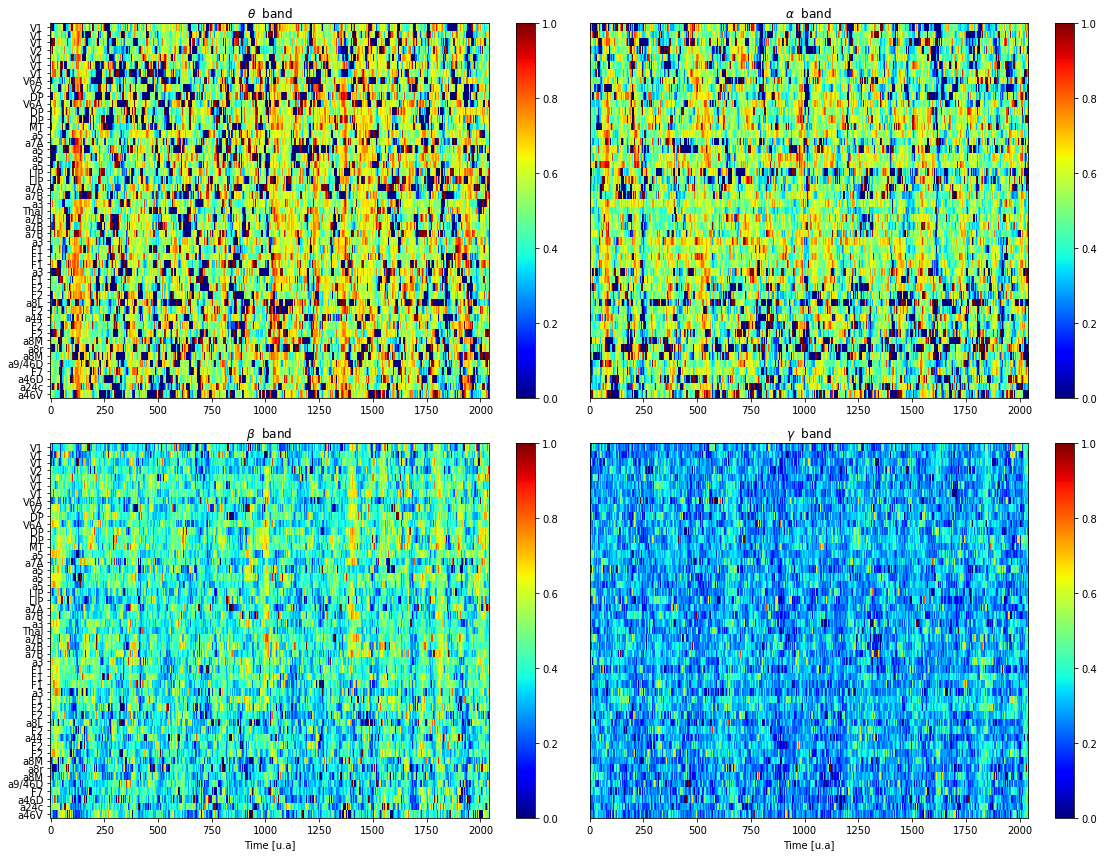

In [88]:
plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plt.imshow(cl_delta[:,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.yticks(range(49), net.session_info['areas'])
plt.title(r'$\theta$  band')
plt.subplot(2,2,2)
plt.imshow(cl_alpha[:,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.yticks([])
plt.title(r'$\alpha$  band')
plt.subplot(2,2,3)
plt.imshow(cl_beta[:,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.yticks(range(49), net.session_info['areas'])
plt.title(r'$\beta$  band')
plt.xlabel('Time [u.a]')
plt.subplot(2,2,4)
plt.imshow(cl_gamma[:,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.yticks([])
plt.title(r'$\gamma$  band')
plt.xlabel('Time [u.a]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/raster_clustering.png')

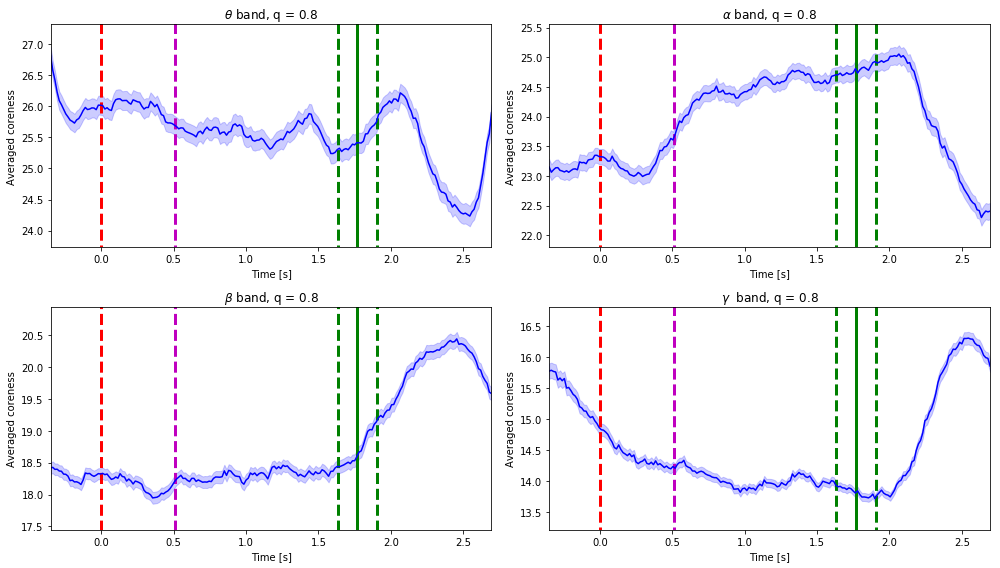

In [89]:
plt.figure(figsize=(14,8))
for j in range( len(net.bands) ):
    plt.subplot(2,2,j+1)
    if j == 0: s_d = np.nan_to_num(cl_delta).sum(axis=0)
    if j == 1: s_d = np.nan_to_num(cl_alpha).sum(axis=0)
    if j == 2: s_d = np.nan_to_num(cl_beta).sum(axis=0)
    if j == 3: s_d = np.nan_to_num(cl_gamma).sum(axis=0)
    #s_d = net.coreness[1,:,j,:].sum(axis=0)
    s_d = s_d.reshape(540,len(net.tarray))
    s_d_m = s_d.mean(axis = 0)
    s_d_e = s_d.std(axis = 0) / (s_d.shape[0]**0.5)
    plt.plot(net.tarray, s_d_m, color = 'b')
    plt.fill_between(net.tarray, s_d_m-s_d_e, s_d_m+s_d_e, color = 'b', alpha = .2)
    plt.title(bands[j] + ' band, q = 0.8')
    plt.xlim([net.tarray[0],net.tarray[-1]])
    plt.ylim([s_d_m.min()-0.5, s_d_m.max()+.5])
    plt.vlines(0, s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='-', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+8, linestyle='--', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+8, linestyle='--', linewidth = 3, color = 'g')
    plt.ylabel('Averaged coreness')
    plt.xlabel('Time [s]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/summed_clustering.png')

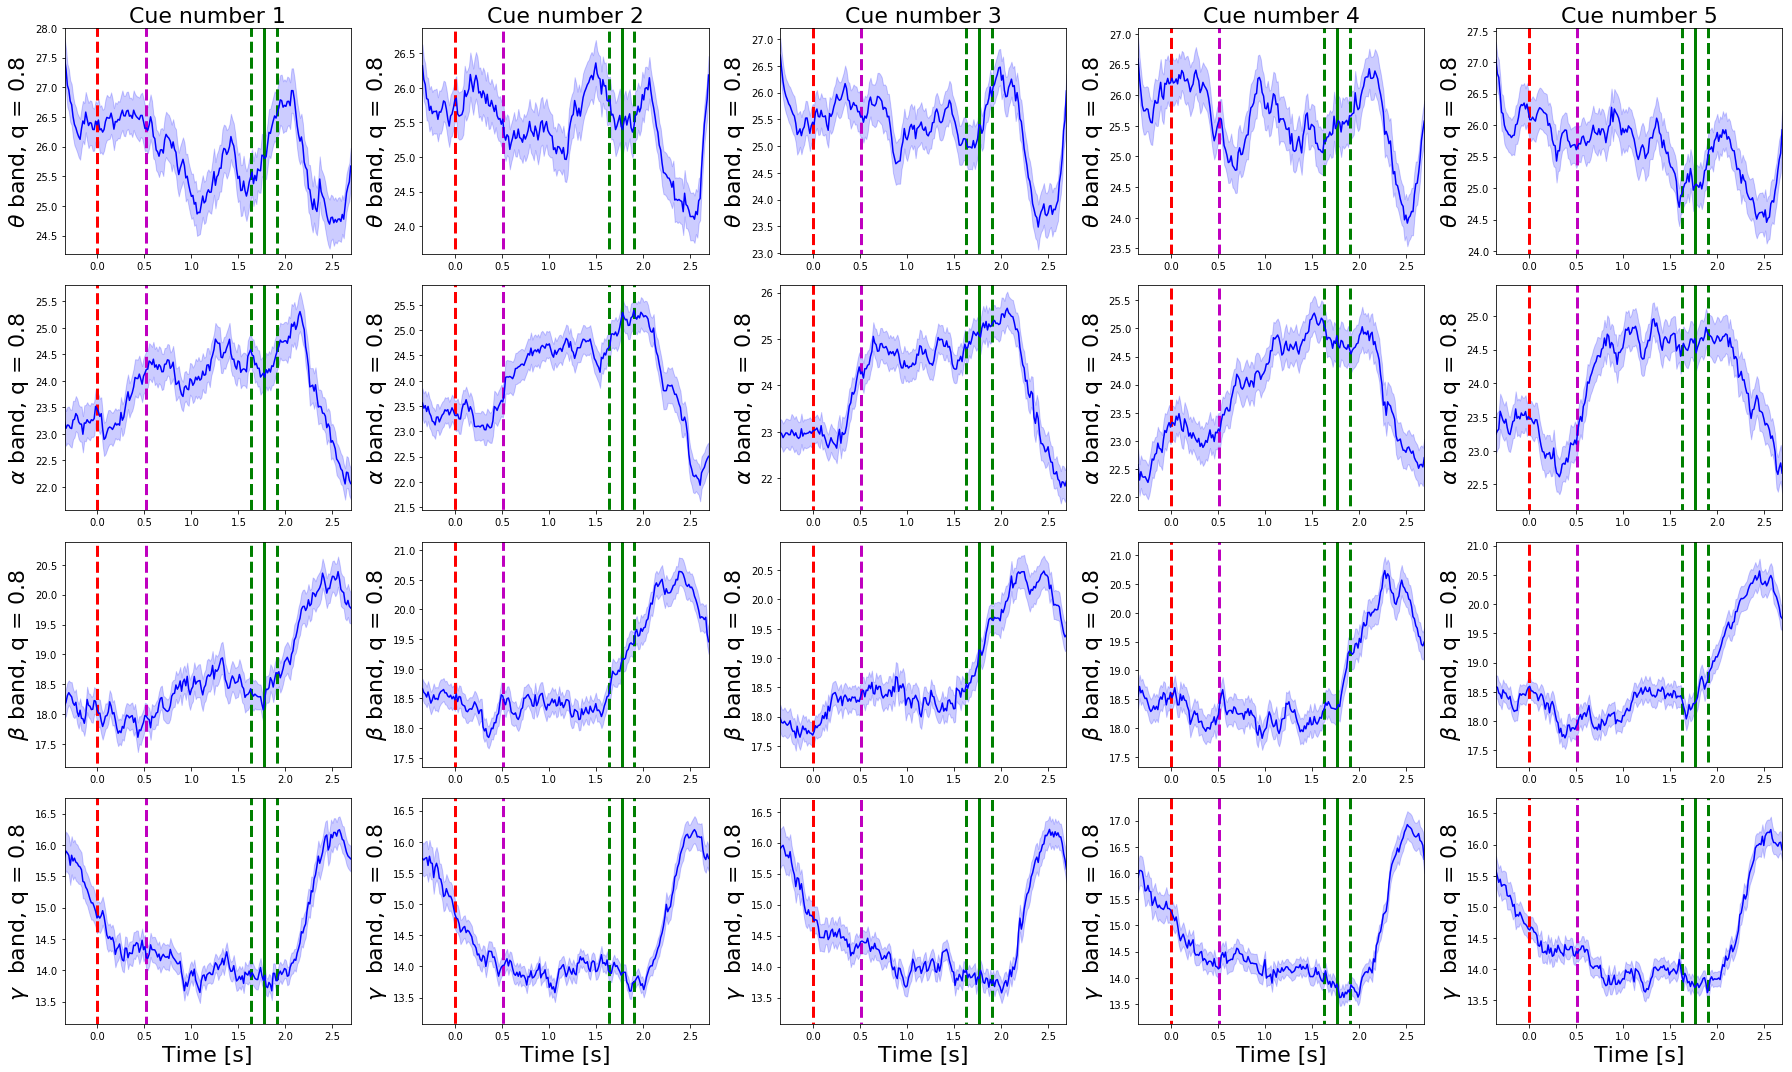

In [90]:
idx = 1
plt.figure(figsize=(25,15))
for i in range( len(net.bands) ):
    for j in range( net.stim_grid.shape[0] ):
        # Computing average over trials for specific cue number
        nt  = np.sum(net.session_info['stim']==j)
        if i == 0: s_d = np.nan_to_num(cl_delta).sum(axis=0)
        if i == 1: s_d = np.nan_to_num(cl_alpha).sum(axis=0)
        if i == 2: s_d = np.nan_to_num(cl_beta).sum(axis=0)
        if i == 3: s_d = np.nan_to_num(cl_gamma).sum(axis=0)
        #s_d = net.coreness[1,:,i,:].sum(axis=0)
        s_d = s_d[net.stim_grid[j].astype(bool)].reshape(nt, len(net.tarray))
        s_d_m = s_d.mean(axis = 0)
        s_d_e = s_d.std(axis = 0) / (s_d.shape[0]**0.5)
        # plot
        plt.subplot( len(net.bands), net.stim_grid.shape[0], idx)
        plt.plot(net.tarray, s_d_m, color = 'b')
        plt.fill_between(net.tarray, s_d_m-s_d_e, s_d_m+s_d_e, color = 'b', alpha = .2)
        plt.xlim([net.tarray[0],net.tarray[-1]])
        plt.ylim([s_d_m.min()-.5, s_d_m.max()+.5])
        plt.vlines(0, s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'r')
        plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                   s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'm')
        plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-14, s_d_m.max()+14, linestyle='-', linewidth = 3, color = 'g')
        plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'g')
        plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'g')
        plt.ylabel(bands[i] + ' band, q = 0.8', fontsize=22)
        idx += 1
        if i == 0:
            plt.title('Cue number ' + str(j+1), fontsize=22)
        if i == 3:
            plt.xlabel('Time [s]', fontsize=22)
plt.tight_layout()
plt.savefig('figures/layerwise_net/summed_clustering_bands_cue.png')

### Clustering - chance level (alpha)

In [34]:
start   = time.time()
cl_null = net.compute_null_statistics(net.compute_nodes_clustering, 10, band = 1, thr = net.coh_thr[1], 
                                      use='igraph', randomize = 'edges', 
                                      seed = 10, n_jobs=5)
end   = time.time()
print('Exc. time = ' + str((end-start)/60) + ' min.')

Exc. time = 7.877796387672424 min.


3
2


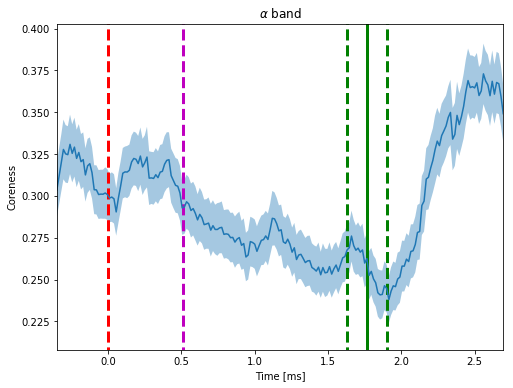

In [91]:
plt.figure(figsize=(8,6))
cl_null = np.array(cl_null)
# null model 
cl_nl = net.reshape_trials(cl_null).mean(axis=0).sum(axis=0)
# Original
cl_or = net.reshape_trials(cl_alpha).sum(axis=0) 
# Excess
E  = (cl_or - cl_nl) / cl_nl 
Em = E.mean(axis=0)
Es = 2*E.std(axis = 0) / np.sqrt(E.shape[0])
# Plot
plt.plot(net.tarray, Em)
plt.fill_between(net.tarray, Em-Es, Em+Es, alpha = .4)
plt.ylim([Em.min()-.03, Em.max()+.03])
plt.xlim([net.tarray[0], net.tarray[-1]])
plt.vlines(0, Em.min()-14, Em.max()+14, linestyle='--', linewidth = 3, color = 'r')
plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                   Em.min()-14, Em.max()+14, linestyle='--', linewidth = 3, color = 'm')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       Em.min()-14, Em.max()+14, linestyle='-', linewidth = 3, color = 'g')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       Em.min()-14, Em.max()+14, linestyle='--', linewidth = 3, color = 'g')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       Em.min()-14, Em.max()+14, linestyle='--', linewidth = 3, color = 'g')
plt.xlabel('Time [ms]')
plt.ylabel(r'Coreness')
plt.title(r'$\alpha$ band')
plt.savefig('figures/layerwise_net/excess_clustering.png')

### Modularity

In [43]:
# Original net
m_delta = net.compute_network_modularity(band=0, thr=net.coh_thr[0], use='igraph', on_null=False)
m_alpha = net.compute_network_modularity(band=1, thr=net.coh_thr[1], use='igraph', on_null=False)
m_beta  = net.compute_network_modularity(band=2, thr=net.coh_thr[2], use='igraph', on_null=False)
m_gamma = net.compute_network_modularity(band=3, thr=net.coh_thr[3], use='igraph', on_null=False)


  9%|▉         | 10037/110160 [00:14<02:16, 732.75it/s]


 18%|█▊        | 20274/110160 [00:29<02:09, 691.73it/s]


 28%|██▊       | 30345/110160 [00:43<01:57, 682.18it/s]


 37%|███▋      | 40365/110160 [00:58<01:45, 661.84it/s]


 46%|████▌     | 50435/110160 [01:12<01:29, 668.14it/s]


 55%|█████▌    | 60695/110160 [01:27<01:05, 757.16it/s]


 64%|██████▍   | 70662/110160 [01:41<00:57, 690.95it/s]


 73%|███████▎  | 80700/110160 [01:56<00:41, 711.23it/s]


 82%|████████▏ | 90756/110160 [02:10<00:27, 708.38it/s]


 92%|█████████▏| 100855/110160 [02:25<00:14, 660.79it/s]


100%|██████████| 110160/110160 [02:39<00:00, 692.70it/s]

  0%|          | 475/110160 [00:00<02:42, 676.57it/s]


 10%|▉         | 10618/110160 [00:15<02:18, 719.48it/s]


 19%|█▊        | 20507/110160 [00:29<02:11, 680.54it/s]


 28%|██▊       | 30361/110160 [00:44<02:04, 639.89it/s]


 37%|███▋      | 40313/110160 [00:58<01:37, 717.09it/s]


 46%|████▌     | 50257/110160 [01:13<01:25, 697.34it/s]


 55%|█████▍    | 60263/110160 [01:27<01:12, 684.86it/s]


 64%|██████▍   | 70458/110160 [01:42<00:58, 677.80it/s]


 73%|███████▎  | 80447/110160 [01:56<00:41, 717.71it/s]


 82%|████████▏ | 90599/110160 [02:10<00:29, 660.97it/s]


 91%|█████████▏| 100722/110160 [02:25<00:13, 714.22it/s]


100%|██████████| 110160/110160 [02:38<00:00, 695.40it/s]

  1%|          | 654/110160 [00:01<02:49, 646.44it/s]


  9%|▉         | 10411/110160 [00:15<02:24, 690.93it/s]


 18%|█▊        | 20096/110160 [00:29<02:12, 678.35it/s]


 27%|██▋       | 29771/110160 [00:43<01:57, 685.28it/s]


 36%|███▌      | 39496/110160 [00:58<01:40, 704.82it/s]


 45%|████▍     | 49228/110160 [01:12<01:30, 671.79it/s]


 53%|█████▎    | 58922/110160 [01:26<01:14, 690.41it/s]


 62%|██████▏   | 68649/110160 [01:40<01:00, 690.00it/s]


 71%|███████   | 78341/110160 [01:54<00:49, 640.80it/s]


 80%|███████▉  | 87950/110160 [02:08<00:32, 689.38it/s]


 89%|████████▊ | 97695/110160 [02:23<00:18, 684.09it/s]


 97%|█████████▋| 107357/110160 [02:37<00:04, 680.28it/s]


100%|██████████| 110160/110160 [02:41<00:00, 683.23it/s]

  6%|▌         | 6697/110160 [00:10<02:30, 686.94it/s]


 15%|█▍        | 16322/110160 [00:24<02:18, 679.95it/s]


 24%|██▎       | 25910/110160 [00:38<02:05, 671.77it/s]


 32%|███▏      | 35428/110160 [00:52<01:50, 676.33it/s]


 41%|████      | 44930/110160 [01:06<01:36, 677.35it/s]


 49%|████▉     | 54459/110160 [01:20<01:22, 675.21it/s]


 58%|█████▊    | 63947/110160 [01:34<01:07, 680.11it/s]


 67%|██████▋   | 73360/110160 [01:48<00:54, 673.99it/s]


 75%|███████▌  | 82726/110160 [02:03<00:43, 636.19it/s]


 84%|████████▎ | 92143/110160 [02:17<00:26, 675.69it/s]


 92%|█████████▏| 101551/110160 [02:31<00:13, 647.65it/s]


100%|██████████| 110160/110160 [02:44<00:00, 669.37it/s]


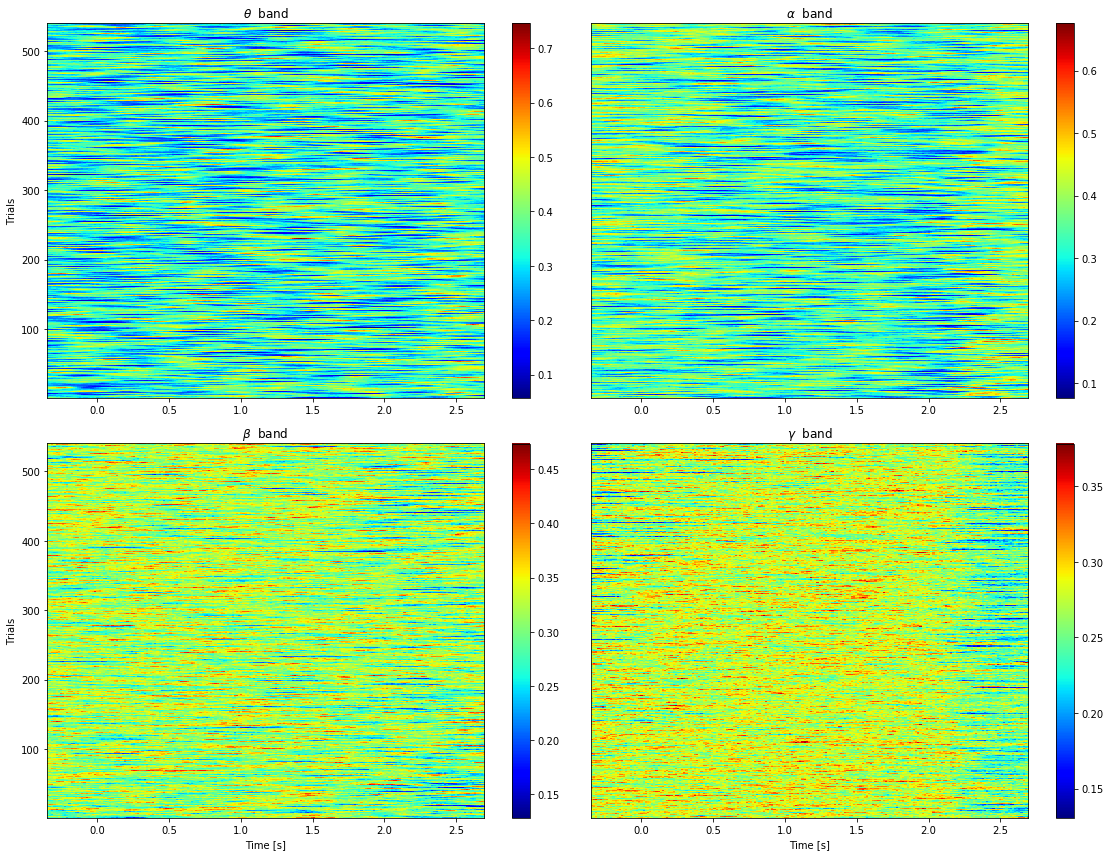

In [92]:
plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plt.imshow(m_delta.reshape([540, len(net.tarray)]), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[net.tarray[0], net.tarray[-1], 1, 540]); plt.colorbar()
plt.ylabel('Trials')
plt.title(r'$\theta$  band')
plt.subplot(2,2,2)
plt.imshow(m_alpha.reshape([540, len(net.tarray)]), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[net.tarray[0], net.tarray[-1], 1, 540]); plt.colorbar()
plt.yticks([])
plt.title(r'$\alpha$  band')
plt.subplot(2,2,3)
plt.imshow(m_beta.reshape([540, len(net.tarray)]), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[net.tarray[0], net.tarray[-1], 1, 540]); plt.colorbar()
plt.title(r'$\beta$  band')
plt.ylabel('Trials')
plt.xlabel('Time [s]')
plt.subplot(2,2,4)
plt.imshow(m_gamma.reshape([540, len(net.tarray)]), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[net.tarray[0], net.tarray[-1], 1, 540]); plt.colorbar()
plt.yticks([])
plt.title(r'$\gamma$  band')
plt.xlabel('Time [s]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/raster_modularity.png')

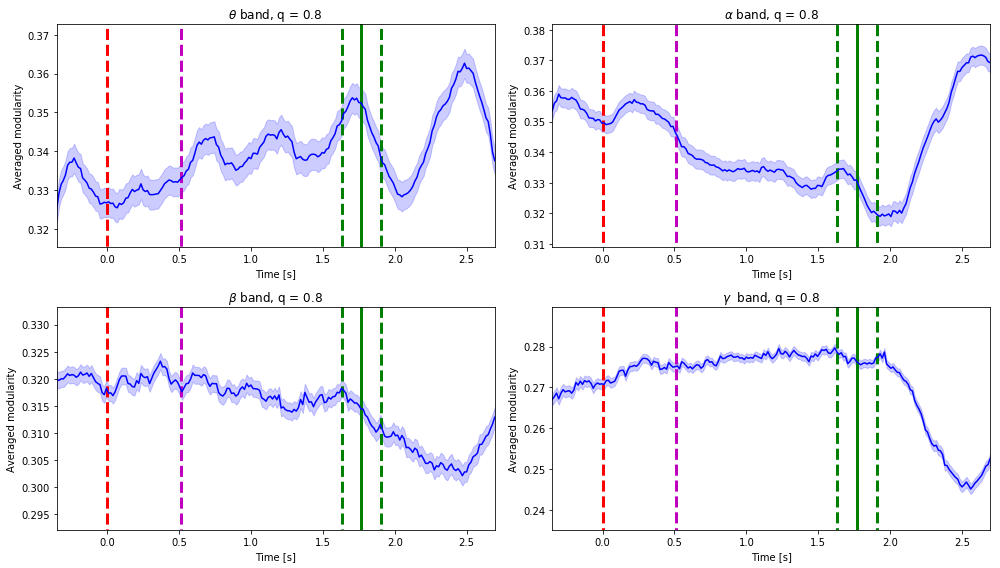

In [93]:
plt.figure(figsize=(14,8))
for j in range( len(net.bands) ):
    plt.subplot(2,2,j+1)
    if j == 0: s_d = m_delta
    if j == 1: s_d = m_alpha
    if j == 2: s_d = m_beta
    if j == 3: s_d = m_gamma
    #s_d = net.coreness[1,:,j,:].sum(axis=0)
    s_d = s_d.reshape(540,len(net.tarray))
    s_d_m = s_d.mean(axis = 0)
    s_d_e = s_d.std(axis = 0) / (s_d.shape[0]**0.5)
    plt.plot(net.tarray, s_d_m, color = 'b')
    plt.fill_between(net.tarray, s_d_m-s_d_e, s_d_m+s_d_e, color = 'b', alpha = .2)
    plt.title(bands[j] + ' band, q = 0.8')
    plt.xlim([net.tarray[0],net.tarray[-1]])
    plt.ylim([s_d_m.min()-0.01, s_d_m.max()+.01])
    plt.vlines(0, s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='-', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+8, linestyle='--', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+8, linestyle='--', linewidth = 3, color = 'g')
    plt.ylabel('Averaged modularity')
    plt.xlabel('Time [s]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/summed_modularity.png')

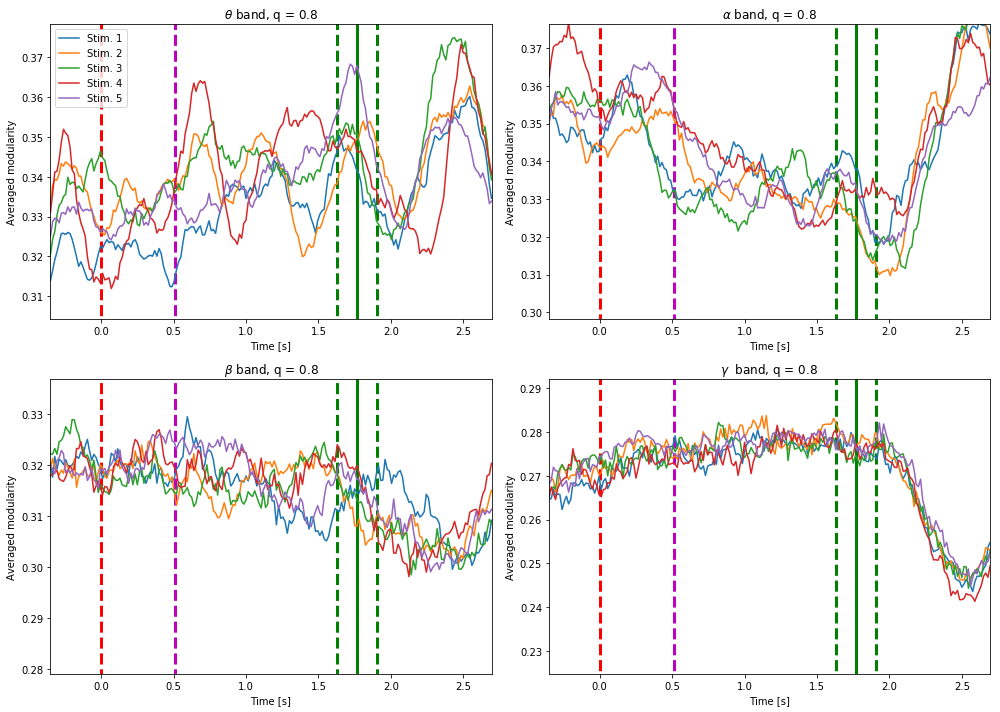

In [94]:
plt.figure(figsize=(14,10))
for j in range( len(net.bands) ):
    plt.subplot(2,2,j+1)
    if j == 0: s_d = m_delta
    if j == 1: s_d = m_alpha
    if j == 2: s_d = m_beta
    if j == 3: s_d = m_gamma
    for i in range(net.stim_grid.shape[0]):
        nt  = np.sum(net.session_info['stim']==i)
        s_d_aux = s_d[net.stim_grid[i].astype(bool)].copy()
        s_d_aux = s_d_aux.reshape(nt,len(net.tarray))
        s_d_m = s_d_aux.mean(axis = 0)
        s_d_e = s_d_aux.std(axis = 0) / (s_d.shape[0]**0.5)
        plt.plot(net.tarray, s_d_m)
        plt.fill_between(net.tarray, s_d_m-s_d_e, s_d_m+s_d_e, alpha = .2)
    plt.title(bands[j] + ' band, q = 0.8')
    plt.xlim([net.tarray[0],net.tarray[-1]])
    plt.ylim([s_d_m.min()-0.02, s_d_m.max()+.01])
    plt.vlines(0, s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='-', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+8, linestyle='--', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+8, linestyle='--', linewidth = 3, color = 'g')
    if j == 0:
        plt.legend(['Stim. 1', 'Stim. 2', 'Stim. 3', 'Stim. 4', 'Stim. 5'])
    plt.ylabel('Averaged modularity')
    plt.xlabel('Time [s]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/modularity_cues.png')

### Modularity - chance level (alpha)

In [47]:
start   = time.time()
m_null = net.compute_null_statistics(net.compute_network_modularity, 10, band = 1, thr = net.coh_thr[1], 
                                      use='igraph', randomize = 'edges', 
                                      seed = 1, n_jobs=5)
end   = time.time()
print('Exc. time = ' + str((end-start)/60) + ' min.')

Exc. time = 10.02342750231425 min.


2
1


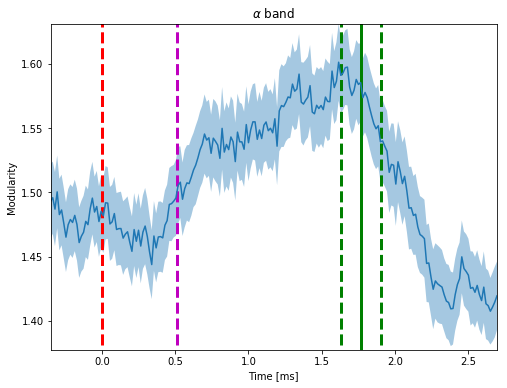

In [95]:
plt.figure(figsize=(8,6))
m_null = np.array(m_null)
# null model 
m_nl = net.reshape_trials(m_null).mean(axis=0)
# Original
m_or = net.reshape_trials(m_alpha)
# Excess
E  = (m_or - m_nl) / m_nl 
Em = E.mean(axis=0)
Es = 2*E.std(axis = 0) / np.sqrt(E.shape[0])
# Plot
plt.plot(net.tarray, Em)
plt.fill_between(net.tarray, Em-Es, Em+Es, alpha = .4)
plt.ylim([Em.min()-.03, Em.max()+.03])
plt.xlim([net.tarray[0], net.tarray[-1]])
plt.vlines(0, Em.min()-14, Em.max()+14, linestyle='--', linewidth = 3, color = 'r')
plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                   Em.min()-14, Em.max()+14, linestyle='--', linewidth = 3, color = 'm')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       Em.min()-14, Em.max()+14, linestyle='-', linewidth = 3, color = 'g')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       Em.min()-14, Em.max()+14, linestyle='--', linewidth = 3, color = 'g')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       Em.min()-14, Em.max()+14, linestyle='--', linewidth = 3, color = 'g')
plt.xlabel('Time [ms]')
plt.ylabel(r'Modularity')
plt.title(r'$\alpha$ band')
plt.savefig('figures/layerwise_net/excess_modularity.png')

### Allegiance  matrix (theta band)

In order to compute the allegiance matrix we first have to compute the layerwise community labes of each node in order to verity how often they fall in the same module, the allegiance matrix can be computed by using the method __compute_allegiance_matrix__. If the parameter __per_task_stage__ is set to true the allegiance matrix will be computed separately for each stage.

In [96]:
T = net.compute_allegiance_matrix(band=0, thr=net.coh_thr[0], use='igraph', per_task_stage=True)


  9%|▉         | 10022/110160 [00:14<02:19, 720.12it/s]


 18%|█▊        | 20123/110160 [00:29<02:13, 674.15it/s]


 27%|██▋       | 30135/110160 [00:43<01:54, 699.98it/s]


 36%|███▋      | 39992/110160 [00:58<01:46, 656.95it/s]


 45%|████▌     | 49849/110160 [01:13<02:01, 497.06it/s]


 54%|█████▍    | 59743/110160 [01:27<01:17, 651.42it/s]


 63%|██████▎   | 69449/110160 [01:42<00:57, 708.09it/s]


 72%|███████▏  | 79032/110160 [01:56<00:51, 608.72it/s]


 81%|████████  | 88683/110160 [02:11<00:29, 716.06it/s]


 89%|████████▉ | 98390/110160 [02:25<00:17, 684.53it/s]


 98%|█████████▊| 107822/110160 [02:40<00:03, 673.95it/s]


100%|██████████| 110160/110160 [02:43<00:00, 672.16it/s]

100%|██████████| 12960/12960 [00:07<00:00, 1808.06it/s]

 36%|███▌      | 6633/18360 [00:03<00:06, 1886.80it/s]


100%|██████████| 18360/18360 [00:10<00:00, 1822.53it/s]

 31%|███       | 13883/45210 [00:08<00:17, 1761.59it/s]


 85%|████████▍ | 38246/45210 [00:22<00:04, 1728.53it/s]


100%|██████████| 45210/45210 [00:26<00:00, 1709.48it/s]

 52%|█████▏    | 17635/33630 [00:10<00:09, 1646.69it/s]


100%|██████████| 33630/33630 [00:19<00:00, 1718.86it/s]


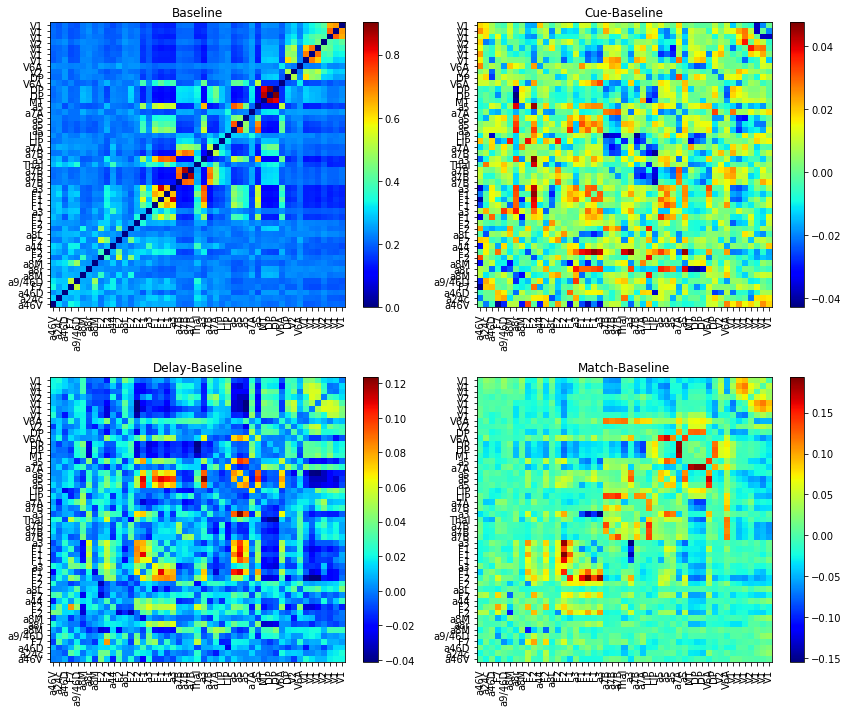

In [101]:
title = ['Baseline', 'Cue-Baseline', 'Delay-Baseline', 'Match-Baseline']
plt.figure(figsize=(12,10))
for k in range(4):
    plt.subplot(2,2,k+1)
    if k > 0:
        plt.imshow(T[k]-T[0], aspect = 'auto', cmap = 'jet', origin = 'lower')
    else:
        plt.imshow(T[k], aspect = 'auto', cmap = 'jet', origin = 'lower')
    plt.colorbar()
    plt.xticks(range(49), net.session_info['areas'], rotation = 90)
    plt.yticks(range(49), net.session_info['areas'])
    plt.title(title[k])
plt.tight_layout()
plt.savefig('figures/layerwise_net/allegiance_theta.png')

### Allegiance  matrix (alpha band)

In [100]:
T = net.compute_allegiance_matrix(band=1, thr=net.coh_thr[1], use='igraph', per_task_stage=True)


  9%|▉         | 9978/110160 [00:14<02:32, 656.52it/s]


 18%|█▊        | 19813/110160 [00:29<02:15, 665.22it/s]


 27%|██▋       | 29434/110160 [00:43<01:56, 693.48it/s]


 35%|███▌      | 39091/110160 [00:57<01:45, 674.69it/s]


 44%|████▍     | 48687/110160 [01:12<01:31, 670.11it/s]


 53%|█████▎    | 58221/110160 [01:26<01:21, 637.23it/s]


 62%|██████▏   | 67824/110160 [01:41<01:03, 664.23it/s]


 70%|███████   | 77272/110160 [01:55<00:48, 678.48it/s]


 79%|███████▉  | 86860/110160 [02:10<00:35, 652.94it/s]


 88%|████████▊ | 96563/110160 [02:24<00:20, 670.99it/s]


 96%|█████████▋| 106149/110160 [02:39<00:05, 686.72it/s]


100%|██████████| 110160/110160 [02:45<00:00, 667.23it/s]

100%|██████████| 12960/12960 [00:05<00:00, 2182.88it/s]

 27%|██▋       | 5020/18360 [00:02<00:06, 2118.14it/s]


100%|██████████| 18360/18360 [00:08<00:00, 2105.13it/s]

 38%|███▊      | 17136/45210 [00:07<00:12, 2247.20it/s]


100%|██████████| 45210/45210 [00:20<00:00, 2183.86it/s]

  8%|▊         | 2747/33630 [00:01<00:14, 2144.31it/s]


 98%|█████████▊| 32950/33630 [00:15<00:00, 2115.23it/s]


100%|██████████| 33630/33630 [00:15<00:00, 2119.63it/s]


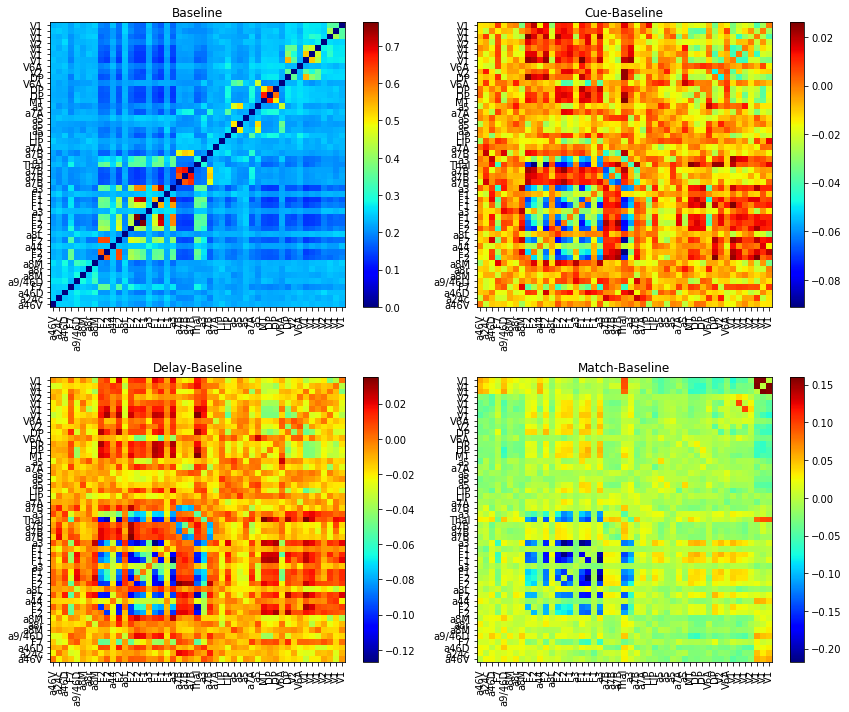

In [107]:
title = ['Baseline', 'Cue-Baseline', 'Delay-Baseline', 'Match-Baseline']
plt.figure(figsize=(12,10))
for k in range(4):
    plt.subplot(2,2,k+1)
    if k > 0:
        plt.imshow(T[k]-T[0], aspect = 'auto', cmap = 'jet', origin = 'lower')
    else:
        plt.imshow(T[k], aspect = 'auto', cmap = 'jet', origin = 'lower')
    plt.colorbar()
    plt.xticks(range(49), net.session_info['areas'], rotation = 90)
    plt.yticks(range(49), net.session_info['areas'])
    plt.title(title[k])
plt.tight_layout()
plt.savefig('figures/layerwise_net/allegiance_alpha.png')

### Allegiance  matrix (beta band)

In [103]:
T = net.compute_allegiance_matrix(band=2, thr=net.coh_thr[2], use='igraph', per_task_stage=True)


  9%|▊         | 9551/110160 [00:14<02:34, 653.00it/s]


 17%|█▋        | 19062/110160 [00:28<02:19, 652.84it/s]


 26%|██▌       | 28551/110160 [00:43<02:03, 660.30it/s]


 34%|███▍      | 37791/110160 [00:57<02:18, 523.42it/s]


 43%|████▎     | 47114/110160 [01:11<01:33, 675.87it/s]


 51%|█████▏    | 56501/110160 [01:25<01:22, 650.87it/s]


 60%|█████▉    | 65717/110160 [01:40<01:06, 663.92it/s]


 68%|██████▊   | 74885/110160 [01:54<00:55, 636.17it/s]


 76%|███████▋  | 84120/110160 [02:08<00:40, 639.23it/s]


 85%|████████▍ | 93362/110160 [02:23<00:25, 647.09it/s]


 93%|█████████▎| 102480/110160 [02:37<00:12, 638.83it/s]


100%|██████████| 110160/110160 [02:49<00:00, 651.53it/s]

 38%|███▊      | 4925/12960 [00:02<00:03, 2252.29it/s]


100%|██████████| 12960/12960 [00:05<00:00, 2220.85it/s]

100%|██████████| 18360/18360 [00:08<00:00, 2206.07it/s]

 11%|█         | 4880/45210 [00:02<00:18, 2157.90it/s]


 80%|███████▉  | 36065/45210 [00:16<00:04, 2247.86it/s]


100%|██████████| 45210/45210 [00:20<00:00, 2218.89it/s]

 71%|███████   | 23738/33630 [00:10<00:04, 2323.15it/s]


100%|██████████| 33630/33630 [00:14<00:00, 2337.50it/s]


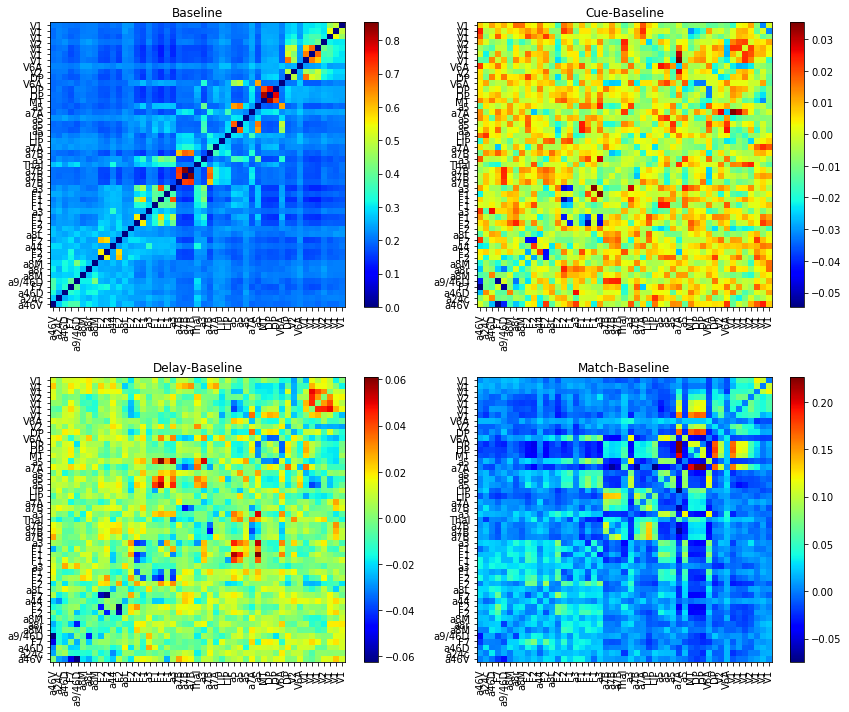

In [104]:
title = ['Baseline', 'Cue-Baseline', 'Delay-Baseline', 'Match-Baseline']
plt.figure(figsize=(12,10))
for k in range(4):
    plt.subplot(2,2,k+1)
    if k > 0:
        plt.imshow(T[k]-T[0], aspect = 'auto', cmap = 'jet', origin = 'lower')
    else:
        plt.imshow(T[k], aspect = 'auto', cmap = 'jet', origin = 'lower')
    plt.colorbar()
    plt.xticks(range(49), net.session_info['areas'], rotation = 90)
    plt.yticks(range(49), net.session_info['areas'])
    plt.title(title[k])
plt.tight_layout()
plt.savefig('figures/layerwise_net/allegiance_beta.png')

### Allegiance  matrix (gamma band)

In [105]:
T = net.compute_allegiance_matrix(band=3, thr=net.coh_thr[3], use='igraph', per_task_stage=True)


  9%|▊         | 9575/110160 [00:14<02:29, 675.02it/s]


 17%|█▋        | 18933/110160 [00:28<02:16, 666.53it/s]


 26%|██▌       | 28267/110160 [00:42<02:11, 623.95it/s]


 34%|███▍      | 37429/110160 [00:56<01:49, 661.39it/s]


 42%|████▏     | 46636/110160 [01:11<01:35, 663.56it/s]


 51%|█████     | 55794/110160 [01:25<01:24, 644.94it/s]


 59%|█████▉    | 64974/110160 [01:39<01:09, 646.40it/s]


 67%|██████▋   | 74078/110160 [01:53<00:56, 640.76it/s]


 75%|███████▌  | 83153/110160 [02:07<00:42, 629.11it/s]


 84%|████████▎ | 92104/110160 [02:22<00:27, 649.18it/s]


 92%|█████████▏| 101107/110160 [02:36<00:14, 642.01it/s]


100%|█████████▉| 109973/110160 [02:50<00:00, 612.47it/s]


100%|██████████| 110160/110160 [02:50<00:00, 645.34it/s]

100%|██████████| 12960/12960 [00:06<00:00, 2133.73it/s]

 92%|█████████▏| 16901/18360 [00:07<00:00, 2195.88it/s]


100%|██████████| 18360/18360 [00:08<00:00, 2170.03it/s]

 64%|██████▍   | 28900/45210 [00:13<00:07, 2217.34it/s]


100%|██████████| 45210/45210 [00:20<00:00, 2175.53it/s]

 41%|████      | 13744/33630 [00:06<00:09, 2028.29it/s]


100%|██████████| 33630/33630 [00:16<00:00, 2085.03it/s]


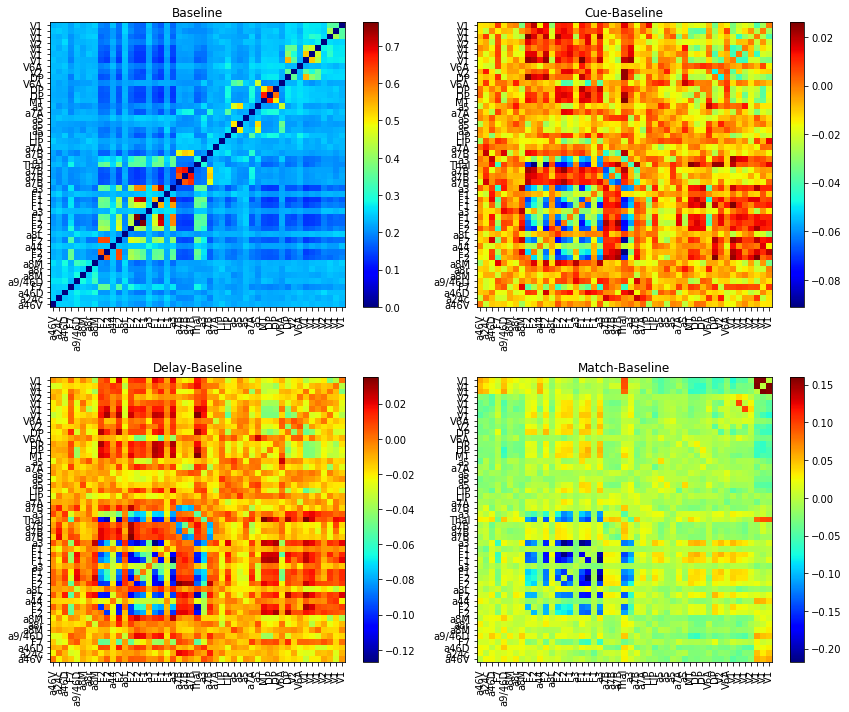

In [106]:
title = ['Baseline', 'Cue-Baseline', 'Delay-Baseline', 'Match-Baseline']
plt.figure(figsize=(12,10))
for k in range(4):
    plt.subplot(2,2,k+1)
    if k > 0:
        plt.imshow(T[k]-T[0], aspect = 'auto', cmap = 'jet', origin = 'lower')
    else:
        plt.imshow(T[k], aspect = 'auto', cmap = 'jet', origin = 'lower')
    plt.colorbar()
    plt.xticks(range(49), net.session_info['areas'], rotation = 90)
    plt.yticks(range(49), net.session_info['areas'])
    plt.title(title[k])
plt.tight_layout()
plt.savefig('figures/layerwise_net/allegiance_gamma.png')

### Saving snapshots to produce gifs

The cell bellow saves the measures above for each trial (in the alpha band) in order to produce a GIF with the maps later.

In [41]:
plt.figure(figsize=(12,8))
for i in tqdm( range(net.session_info['nT']) ):
    plt.figure()
    plt.imshow(st_alpha[:,i*244:(i+1)*244], aspect = 'auto', cmap = 'jet', origin = 'lower', vmax=15, extent=[-0.65,3.00,0,48]); plt.colorbar()
    plt.vlines(0, 0, 48, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'g')
    plt.yticks(range(49), net.session_info['areas'])
    plt.title('Trial = ' + str(i+1))
    plt.savefig('figures/st_alpha'+str(i)+'.png')
    plt.close()

100%|██████████| 540/540 [03:22<00:00,  2.67it/s]


<Figure size 864x576 with 0 Axes>

In [ ]:
plt.figure(figsize=(12,8))
for i in tqdm( range(net.session_info['nT']) ):
    plt.figure()
    plt.imshow(kc_alpha[:,i*244:(i+1)*244], aspect = 'auto', cmap = 'jet', origin = 'lower', vmax=15, extent=[-0.65,3.00,0,48]); plt.colorbar()
    plt.vlines(0, 0, 48, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'g')
    plt.yticks(range(49), net.session_info['areas'])
    plt.title('Trial = ' + str(i+1) + ', threshold = 0.7')
    plt.savefig('figures/core_alpha_'+str(i)+'.png')
    plt.close()


 29%|██▊       | 155/540 [00:56<01:53,  3.38it/s]


 31%|███       | 168/540 [01:01<02:02,  3.04it/s]


In [ ]:
plt.figure(figsize=(12,8))
for i in tqdm( range(net.session_info['nT']) ):
    plt.figure()
    plt.imshow(cl_alpha[:,i*244:(i+1)*244], aspect = 'auto', cmap = 'jet', origin = 'lower', vmax=1, extent=[-0.65,3.00,0,48]); plt.colorbar()
    plt.vlines(0, 0, 48, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'g')
    plt.yticks(range(49), net.session_info['areas'])
    plt.title('Trial = ' + str(i+1) + ', threshold = ' + str(net.coh_thr['1']))
    plt.savefig('figures/clustering_alpha_'+str(i)+'.png')
    plt.close()

### Plotting on the brain sketch

In [18]:
from GDa.graphics.plot_brain_sketch import plot_node_brain_sketch, plot_edge_brain_sketch

In [19]:
#for i in range(244):
#    plt.figure()
#    plot_node_brain_sketch(net.session_info['channels_labels'].astype(int), net.A[:,0,i])

In [21]:
# Brain nets

for i in tqdm( range(net.tarray.shape[0]) ):
    if net.tarray[i] < 0:
        color = 'r'
        title = 'Baseline'
    if net.tarray[i] >= 0 and net.tarray[i] < (net.session_info['t_cue_off'][0]-net.session_info['t_cue_on'][0])/1000:
        color = 'b'
        title = 'Cue'
    if net.tarray[i] >= (net.session_info['t_cue_off'][0]-net.session_info['t_cue_on'][0])/1000 and net.tarray[i] < (net.session_info['t_match_on'][0]-net.session_info['t_cue_on'][0])/1000:
        color = 'm'
        title = 'Delay'
    if net.tarray[i] >= (net.session_info['t_match_on'][0]-net.session_info['t_cue_on'][0])/1000:
        color = 'k'
        title = 'Match'
    w = net.super_tensor[:,1,i]>net.coh_thr[1]
    plot_edge_brain_sketch(net.session_info['pairs'], net.session_info['channels_labels'].astype(int), w, edge_color = color)
    plt.title(title)
    plt.savefig('figures/net_'+str(i)+'.png')
    plt.close()



100%|██████████| 204/204 [10:25<00:00,  3.07s/it]


In [24]:
from matplotlib        import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
viridis = cm.get_cmap('jet', 10)

xy                = scipy.io.loadmat('Brain Areas/lucy_brainsketch_xy.mat')['xy'] # Channels coordinates
ethyl_brainsketch = scipy.ndimage.imread('Brain Areas/ethyl_brainsketch.jpg')     # Brainsketch 

/opt/ohpc/pub/libs/gnu8/python/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


In [40]:
M = np.zeros([49, net.A.shape[-1]])
for t in tqdm( range(net.A.shape[-1]) ):
    n_comm = len(p[t])
    for j, i in zip(range(n_comm), list(p[t])):
        M[i,t] = j 

100%|██████████| 110160/110160 [00:03<00:00, 33525.21it/s]


In [53]:
for i in tqdm( range(540) ):
    plt.figure(figsize=(10,8))
    plt.imshow(M[:, i*204:(i+1)*204], aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[net.tarray[0], net.tarray[-1],0,49])
    plt.yticks(range(49), net.session_info['areas'])
    plt.vlines(0, 0, 49, linestyle='--', linewidth = 6, color = 'r')
    plt.vlines((net.session_info['t_cue_off'][i]-net.session_info['t_cue_on'][i])/1000, 
                   0, 49, linestyle='--', linewidth = 6, color = 'r')
    plt.vlines((net.session_info['t_match_on'][i]-net.session_info['t_cue_on'][i])/1000, 
                  0, 49, linestyle='--', linewidth = 6, color = 'r')
    plt.savefig('figures/comm_mat'+str(i)+'.png')
    plt.close()

100%|██████████| 540/540 [02:42<00:00,  3.33it/s]


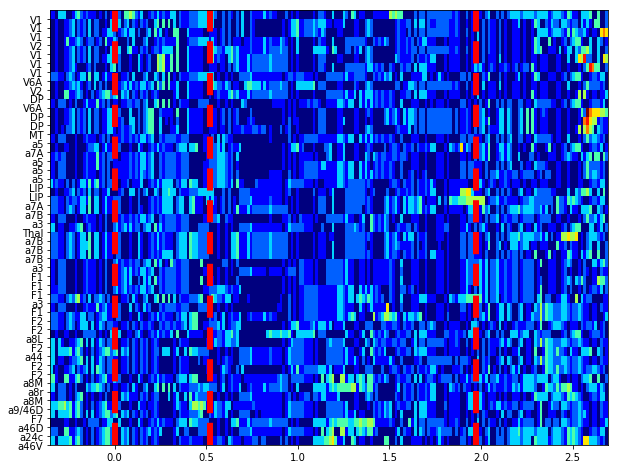

In [54]:
    i = 0
    plt.figure(figsize=(10,8))
    plt.imshow(M[:, i*204:(i+1)*204], aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[net.tarray[0], net.tarray[-1],0,49])
    plt.yticks(range(49), net.session_info['areas'])
    plt.vlines(0, 0, 49, linestyle='--', linewidth = 6, color = 'r')
    plt.vlines((net.session_info['t_cue_off'][i]-net.session_info['t_cue_on'][i])/1000, 
                   0, 49, linestyle='--', linewidth = 6, color = 'r')
    plt.vlines((net.session_info['t_match_on'][i]-net.session_info['t_cue_on'][i])/1000, 
                  0, 49, linestyle='--', linewidth = 6, color = 'r')

In [70]:
sm = []
ss = []
for i in p:
    aux = [len(i[t]) for t in range(len(i))]
    sm.append(np.mean(aux))
    ss.append(np.std(aux))
aux = np.reshape(sm, (540,204))

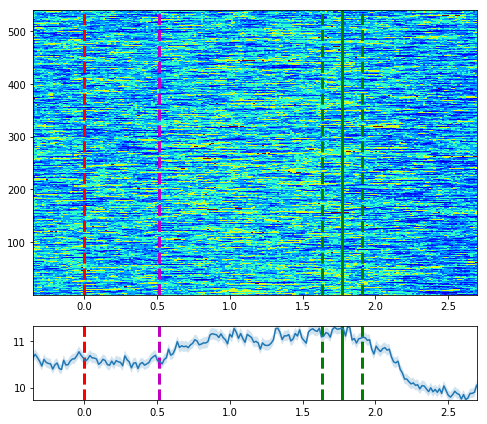

In [71]:
plt.figure(figsize=(10,6))
plt.subplot2grid((4,3), (0,0), colspan = 2, rowspan=3)
plt.imshow(aux, aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[net.tarray[0],net.tarray[-1], 1,540])
plt.vlines(0, 1, 540, linestyle='--', linewidth = 3, color = 'r')
plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                       1, 540, linestyle='--', linewidth = 3, color = 'm')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       1, 540, linestyle='-', linewidth = 3, color = 'g')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       1, 540, linestyle='--', linewidth = 3, color = 'g')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       1, 540, linestyle='--', linewidth = 3, color = 'g')
plt.subplot2grid((4,3), (3,0), colspan = 2, rowspan=1)
aux2  = aux.mean(axis = 0)
aux2e = aux.std(axis = 0) / np.sqrt(aux.shape[0])
plt.errorbar(net.tarray, aux2)
plt.fill_between(net.tarray, aux2-aux2e, aux2+aux2e, alpha=.2)
plt.xlim([net.tarray[0], net.tarray[-1]])
plt.ylim([aux2.min()-0.005, aux2.max()+0.005])
plt.vlines(0, aux2.min()-0.005, aux2.max()+0.005, linestyle='--', linewidth = 3, color = 'r')
plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                       aux2.min()-0.005, aux2.max()+0.005, linestyle='--', linewidth = 3, color = 'm')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       aux2.min()-0.005, aux2.max()+0.005, linestyle='-', linewidth = 3, color = 'g')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       aux2.min()-0.005, aux2.max()+0.005, linestyle='--', linewidth = 3, color = 'g')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       aux2.min()-0.005, aux2.max()+0.005, linestyle='--', linewidth = 3, color = 'g')
plt.tight_layout()

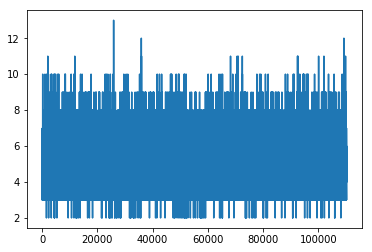

In [58]:
plt.plot(N_comm)

In [34]:
t = 0

In [66]:
for t in tqdm( range(204) ):
    n_comm = len(p[t])
    #flatten = [item for sublist in list(p[i]) for item in sublist]
    plt.figure()
    plt.imshow(ethyl_brainsketch)
    for j, i in zip(range(n_comm), list(p[t])):
        c =  net.session_info['channels_labels'][i].astype(int)
        plt.plot(xy[c-1,0], xy[c-1,1], 'o', color = viridis(j), ms = 15 )
    plt.xticks([])
    plt.yticks([])
    plt.savefig('figures/comm_alpha'+str(t)+'.png')
    plt.close()

100%|██████████| 204/204 [00:21<00:00,  9.70it/s]


In [72]:
n = []
for t in range(len(p)):
    n.append( len(p[t]) )

In [60]:
aux = np.reshape(n, (540, 204) )

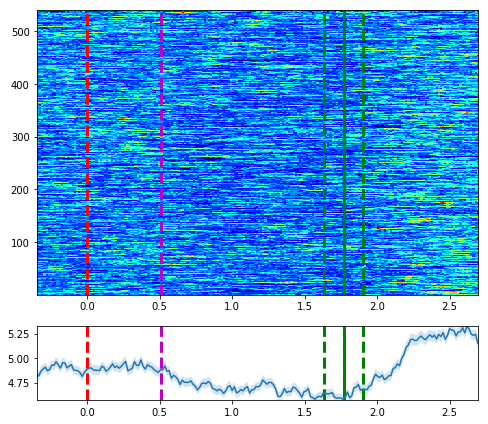

In [63]:
plt.figure(figsize=(10,6))
plt.subplot2grid((4,3), (0,0), colspan = 2, rowspan=3)
plt.imshow(aux, aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[net.tarray[0],net.tarray[-1], 1,540])
plt.vlines(0, 1, 540, linestyle='--', linewidth = 3, color = 'r')
plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                       1, 540, linestyle='--', linewidth = 3, color = 'm')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       1, 540, linestyle='-', linewidth = 3, color = 'g')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       1, 540, linestyle='--', linewidth = 3, color = 'g')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       1, 540, linestyle='--', linewidth = 3, color = 'g')
plt.subplot2grid((4,3), (3,0), colspan = 2, rowspan=1)
aux2  = aux.mean(axis = 0)
aux2e = aux.std(axis = 0) / np.sqrt(aux.shape[0])
plt.errorbar(net.tarray, aux2)
plt.fill_between(net.tarray, aux2-aux2e, aux2+aux2e, alpha=.2)
plt.xlim([net.tarray[0], net.tarray[-1]])
plt.ylim([aux2.min()-0.005, aux2.max()+0.005])
plt.vlines(0, aux2.min()-0.005, aux2.max()+0.005, linestyle='--', linewidth = 3, color = 'r')
plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                       aux2.min()-0.005, aux2.max()+0.005, linestyle='--', linewidth = 3, color = 'm')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       aux2.min()-0.005, aux2.max()+0.005, linestyle='-', linewidth = 3, color = 'g')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       aux2.min()-0.005, aux2.max()+0.005, linestyle='--', linewidth = 3, color = 'g')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       aux2.min()-0.005, aux2.max()+0.005, linestyle='--', linewidth = 3, color = 'g')
plt.tight_layout()

In [74]:
n_mod = np.reshape(n, (540,204))
s_mod = np.reshape(sm, (540,204))

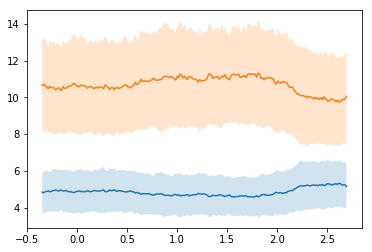

In [77]:
plt.plot(net.tarray, n_mod.mean(axis = 0))
plt.fill_between(net.tarray, n_mod.mean(axis = 0)-n_mod.std(axis = 0), n_mod.mean(axis = 0)+n_mod.std(axis = 0), alpha = .2)
plt.plot(net.tarray, s_mod.mean(axis = 0))
plt.fill_between(net.tarray, s_mod.mean(axis = 0)-s_mod.std(axis = 0), s_mod.mean(axis = 0)+s_mod.std(axis = 0), alpha = .2)

In [42]:
from GDa.graphics.plot_network import plot_temp_net_ring

In [25]:
G = []
for i in range(204):
    g = nx.Graph(net.A[:,:,1,i]>net.coh_thr[1])
    G.append( ig.Graph(49, g.edges) )

In [32]:
leidenalg.find_partition_temporal(G, leidenalg.ModularityVertexPartition, max_comm_size=10)

ValueError: Could not find the vertex attribute id to identify nodes in different slices.

In [35]:
n = 100
G_1 = ig.Graph.Lattice([n], 1)
G_1.vs['id'] = list(range(n))
G_2 = ig.Graph.Lattice([n], 1)
G_2.vs['id'] = list(range(n))
membership, improvement = leidenalg.find_partition_temporal([G_1, G_2],
                                                            leidenalg.ModularityVertexPartition,
                                                            interslice_weight=1)

BaseException: Could not construct partition: Node size vector not the same size as the number of nodes.

In [26]:
a = np.random.rand(5,10)

In [27]:
a

array([[0.40508925, 0.30799091, 0.50351276, 0.83805159, 0.36041634,
        0.61774838, 0.46719542, 0.19789506, 0.81302828, 0.59998457],
       [0.3668012 , 0.44436942, 0.31691264, 0.24319226, 0.08585031,
        0.02040904, 0.25053013, 0.68187461, 0.67555478, 0.6818898 ],
       [0.19008349, 0.99318738, 0.80619669, 0.86106965, 0.49263167,
        0.29128642, 0.69334592, 0.81863737, 0.06184321, 0.04617845],
       [0.20147429, 0.0462776 , 0.47553429, 0.70363217, 0.29802265,
        0.94034861, 0.57592675, 0.58087722, 0.40008143, 0.26841098],
       [0.11974505, 0.09950598, 0.87208371, 0.65738932, 0.52143777,
        0.53352391, 0.5440826 , 0.01437759, 0.47018623, 0.92262529]])

In [29]:
a[[0,2,4],:]

array([[0.40508925, 0.30799091, 0.50351276, 0.83805159, 0.36041634,
        0.61774838, 0.46719542, 0.19789506, 0.81302828, 0.59998457],
       [0.19008349, 0.99318738, 0.80619669, 0.86106965, 0.49263167,
        0.29128642, 0.69334592, 0.81863737, 0.06184321, 0.04617845],
       [0.11974505, 0.09950598, 0.87208371, 0.65738932, 0.52143777,
        0.53352391, 0.5440826 , 0.01437759, 0.47018623, 0.92262529]])

In [31]:
aux = net.compute_null_statistics(net.compute_network_modularity, k = None, band = 1, thr = net.coh_thr[1], 
                                  use='igraph', randomize = 'edges', seed = 10)

100%|██████████| 110160/110160 [03:46<00:00, 485.95it/s]


In [16]:
start = time.time()
measure = net.compute_null_statistics(net.compute_network_modularity, 10, k = None, band = 1, thr = net.coh_thr[1], 
                                  use='igraph', randomize = 'edges', seed = 10 * i, n_jobs = 3)
end = time.time()
print(start-end)

-1050.0295670032501


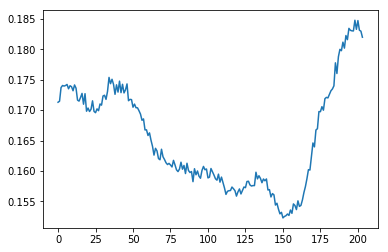

In [33]:
plt.plot(a)

In [23]:
aux = net.reshape_trials(np.array(measure))

2


In [26]:
a = aux.mean(axis = 1)

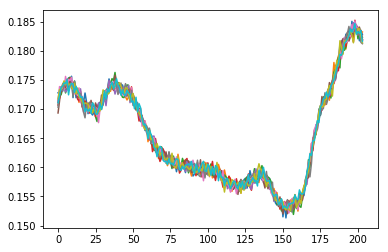

In [27]:
for i in range(10):
    plt.plot(a[i])

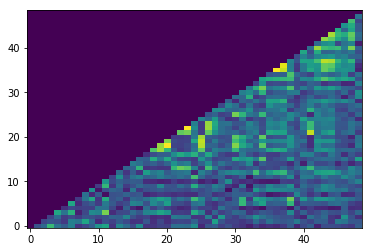

In [17]:
plt.imshow(net.A[:,:,1,0], origin = 'lower', aspect = 'auto')

In [25]:
np.tril(net.A[:,:,1,0], k=0)

(49, 49)

In [27]:
import teneto as tn

In [29]:
tn.TemporalNetwork(net.A[:,:,1,0], 'wu')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [31]:
tnet = tn.TemporalNetwork(from_array=net.A[:,:,1,:], nettype='wu', diagonal=True)

In [33]:
tnet.network.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [47]:
a = net.A[net.session_info['pairs'][:,0],net.session_info['pairs'][:,1],1,:]

In [43]:
net.A[47,48,1,0]

0.3616658039391041

In [42]:
contact = pd.DataFram()

array([[ 0,  1],
       [ 0,  2],
       [ 0,  3],
       ...,
       [46, 47],
       [46, 48],
       [47, 48]])

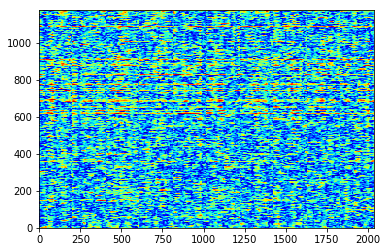

In [49]:
plt.imshow(a[:,:2040], aspect = 'auto', cmap = 'jet', origin = 'lower')

In [126]:
idx  = np.arange( net.session_info['nC'] )
idx_ = np.squeeze([np.random.permutation(idx) for i in range(10000)])
rows = np.arange( net.session_info['nC'] ).reshape(-1,1)

In [127]:
choices            = np.random.randint(len(idx_), size=net.session_info['nC'])
maks               = idx_[choices]

In [111]:
maks[range(net.session_info['nC']),range(net.session_info['nC'])] = range(net.session_info['nC'])

In [113]:
maks[0]

array([ 0, 31, 36,  2,  5, 25,  7, 34,  6,  4, 37, 17, 45, 30, 21, 24, 22,
        8, 28, 38, 29, 48, 43, 23, 35, 41, 27, 33, 44, 15, 40, 10, 46, 11,
       16,  0, 39, 19,  9, 13, 47, 20,  1, 12, 18,  3, 14, 32, 26])

In [128]:
maks

array([[14, 20, 35, ..., 23, 46, 24],
       [29, 14, 27, ...,  5, 35, 26],
       [28, 26, 47, ..., 11, 22,  9],
       ...,
       [30, 26,  6, ..., 10, 29,  0],
       [29, 48, 21, ..., 47, 14, 43],
       [41,  4, 35, ..., 13, 11, 45]])

In [135]:
i = maks == np.arange(net.session_info['nC'])[:, None]

In [136]:
i[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False])

In [139]:
maks[2][i[2]]

array([2])

In [141]:
maks[i] = maks[range(49), range(49)]

In [142]:
maks[range(49), range(49)] = range(49)

In [143]:
maks

array([[ 0, 20, 35, ..., 23, 46, 24],
       [29,  1, 27, ...,  5, 35, 26],
       [28, 26,  2, ..., 11, 22,  9],
       ...,
       [30, 26,  6, ..., 46, 29,  0],
       [29, 48, 21, ..., 14, 47, 43],
       [41,  4, 35, ..., 13, 11, 48]])

array([1176, 1176, 1176, 1176, 1176, 1176, 1176, 1176, 1176, 1176, 1176,
       1176, 1176, 1176, 1176, 1176, 1176, 1176, 1176, 1176, 1176, 1176,
       1176, 1176, 1176, 1176, 1176, 1176, 1176, 1176, 1176, 1176, 1176,
       1176, 1176, 1176, 1176, 1176, 1176, 1176, 1176, 1176, 1176, 1176,
       1176, 1176, 1176, 1176, 1176])